<hr>

# ST1511 AI and Machine Learning CA1 Assignment (Classification)
<hr>

Name: Lee Hong Yi <br>
Class: DAAA/FT/2A/05 <br>
Admin Number: p2223010 <br>

__Objective:__ <br>
Mitigate risk for a bank, by predicting if a customer will default on their payment.

__Background Information:__<br>
A bank has collected data on it's customers, such as their age, gender, level of education, credit limit, and payment history. From this data, the bank would like to predict if a customer would default on their bills, in a attempt to mitigate risk taken.

__Additional Information:__ <br>
A default is a missed or multiple missed payments on money that you have borrowed. An example of a default would be not paying your credit card bill or your monthly mortgage payment. (Investopedia, 2023)

__Prediction Task:__ <br>
Predicting if a customer will default on payments based on information such as gender, education, credit limit, and payment history.

__Output Variable:__ <br>
The output variable indicates if a customer defaulted on their next payment. A 0 indicates that the customer did not default, while a 1 indicates that the customer has defaulted.


<hr>
<font size = 5> Importing Libraries </font>
<hr>

In [1]:
%pip install imblearn

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import RocCurveDisplay, make_scorer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, learning_curve

simplefilter(action='ignore', category=FutureWarning)


Note: you may need to restart the kernel to use updated packages.


In [2]:
sns.set_theme()

<hr>
<font size = 5> Preparing data </font>
<hr><br>
Since the data has already been collected, we can move straight onto preparing the data for training by the model.

Dropping columns, as well as creating a copy of the original dataframe to prevent it from being changed during EDA.

In [3]:
original_data = pd.read_csv("./credit_dataset.csv")
eda_data = original_data.copy()
target_data = original_data["Default payment next month"]
analysis_data = pd.DataFrame(original_data.drop(["Customer ID","Default payment next month"], axis  = 1))
analysis_data.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3
0,20000,female,univeresity,married,24,3913,3102,689,0,689,0
1,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000
2,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000
3,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200
4,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000


<hr>
<font size = 5>Exploratory Data Analysis</font>
<hr><br>
Before preparing the data to train the model, some exploratory data analysis shall be done first to gain some basic insights into the data.

In [4]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Customer ID                 1600 non-null   int64 
 1   Credit Limit                1600 non-null   int64 
 2   Gender                      1600 non-null   object
 3   Education                   1600 non-null   object
 4   Marriage Status             1600 non-null   object
 5   Age                         1600 non-null   int64 
 6   Bill_Amount1                1600 non-null   int64 
 7   Bill_Amount2                1600 non-null   int64 
 8   Bill_Amount3                1600 non-null   int64 
 9   Pay_Amount1                 1600 non-null   int64 
 10  Pay_Amount2                 1600 non-null   int64 
 11  Pay_Amount3                 1600 non-null   int64 
 12  Default payment next month  1600 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 162.6+ KB


From the above, we can see that there are 1600 records in the dataset. The Gender, Education, and Marriage Status columns are not integers, which means they will have to be handled seperately, possibly with one-hot encoding. We can also see that there are no null values in the dataset, which means that we will not have to drop any rows.

In [5]:
gender_count = eda_data["Gender"].value_counts()
education_count = eda_data["Education"].value_counts()
marriage_count = eda_data["Marriage Status"].value_counts()
default_count = eda_data["Default payment next month"].value_counts()

display(gender_count)
display(education_count)
display(marriage_count)
display(default_count)

female    940
male      660
Name: Gender, dtype: int64

univeresity      718
post-graduate    604
high school      278
Name: Education, dtype: int64

single     899
married    701
Name: Marriage Status, dtype: int64

0    1260
1     340
Name: Default payment next month, dtype: int64

Generating a boxplot showing the distribution of Credit Limit and Age.

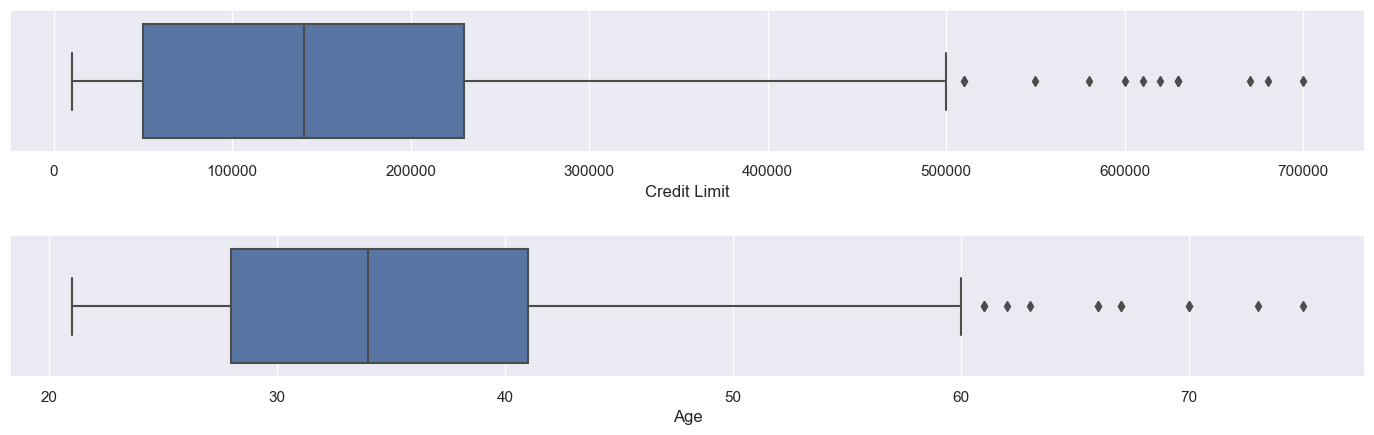

In [6]:
fig, ax = plt.subplots(2,1, figsize = (15,5))

fig.tight_layout(pad = 3.0)
sns.boxplot(data = eda_data, ax = ax[0], x = "Credit Limit")
sns.boxplot(data = eda_data, ax = ax[1], x = "Age")
plt.show()

Generating a boxplot showing the distribution of credit card bill amounts over the 3 months recorded.

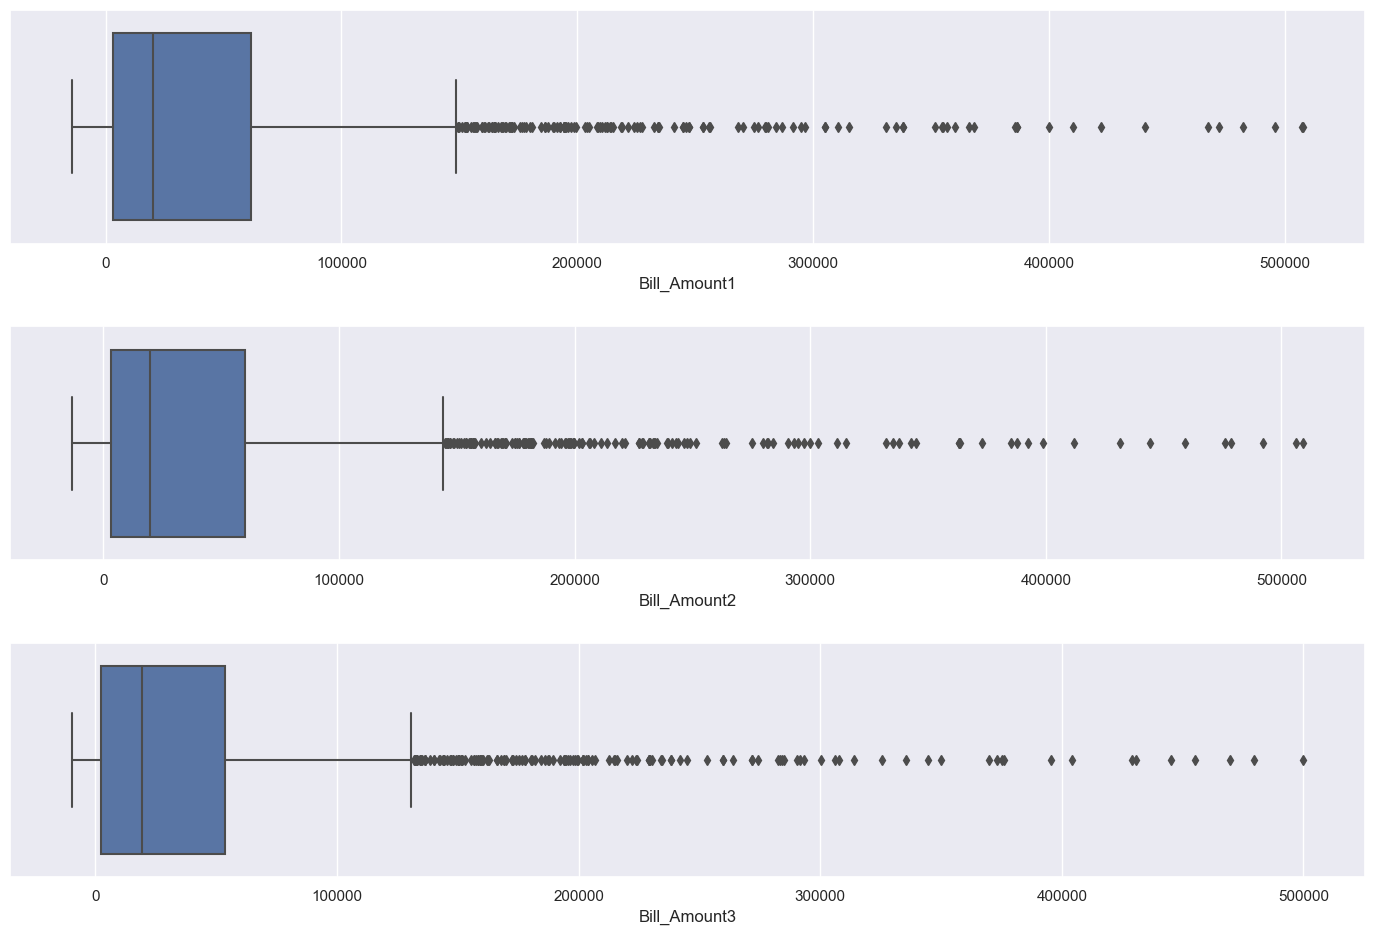

In [7]:
fig, ax = plt.subplots(3,1, figsize = (15,10))

fig.tight_layout(pad = 3.0)
sns.boxplot(data = eda_data, ax = ax[0], x = "Bill_Amount1")
sns.boxplot(data = eda_data, ax = ax[1], x = "Bill_Amount2")
sns.boxplot(data = eda_data, ax = ax[2], x = "Bill_Amount3")

plt.show()

From the above graph, we can see that the average amount paid decreases slightly with each bill.

Generating a boxplot showing the amount each customer paid over the 3 months recorded.

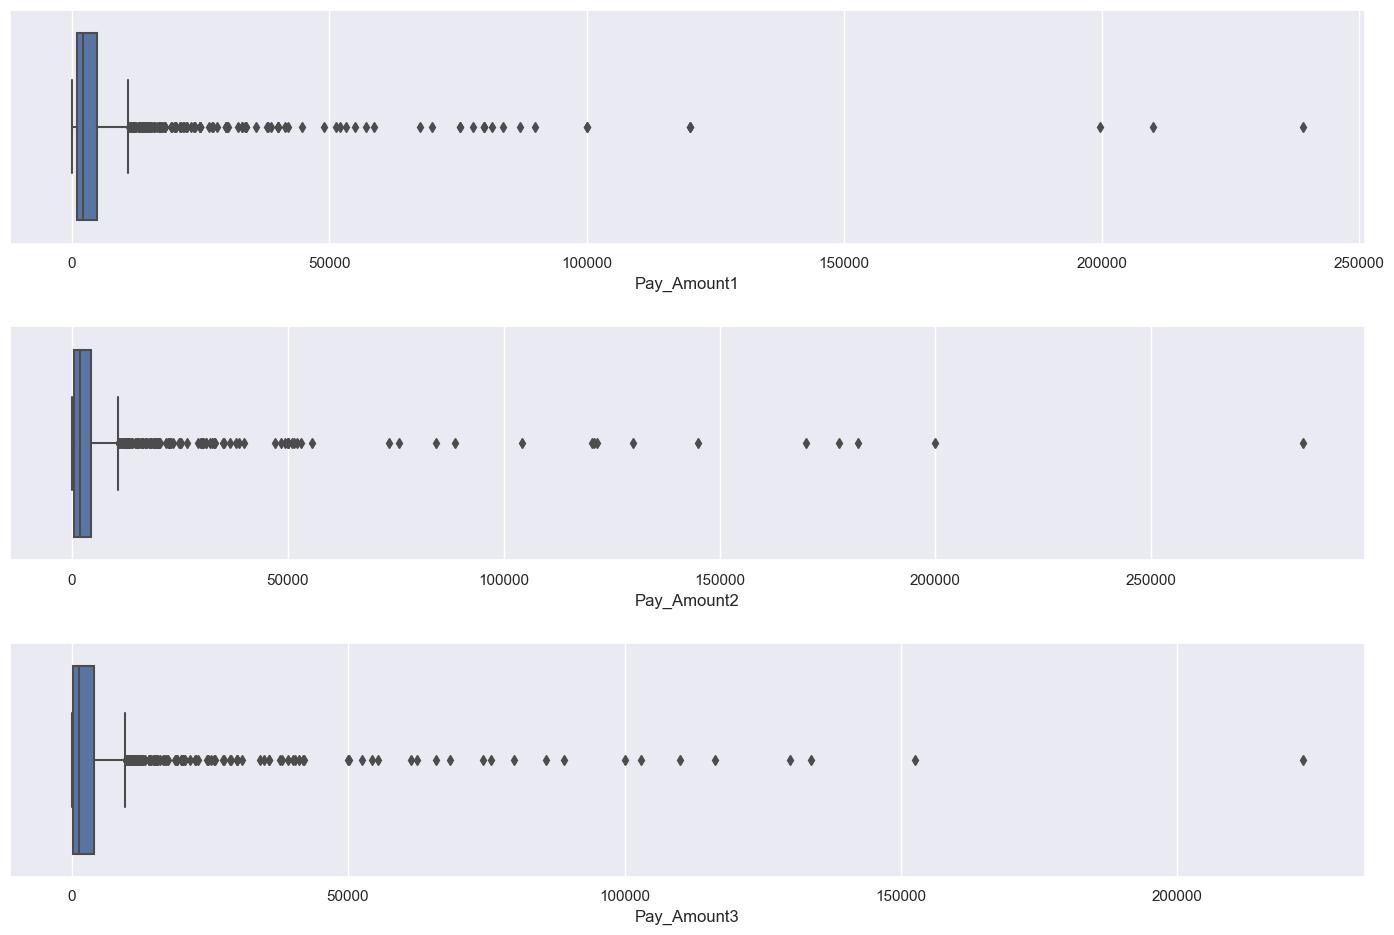

In [8]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
fig.tight_layout(pad = 3.0)
sns.boxplot(data = eda_data, ax = ax[0], x = "Pay_Amount1")
sns.boxplot(data = eda_data, ax = ax[1], x = "Pay_Amount2")
sns.boxplot(data = eda_data, ax = ax[2], x = "Pay_Amount3")
plt.show()

From the above boxplot, we can see that the amount paid also decreases with each payment.

Showing the distribution of defaulters based on the credit limit of the customers.

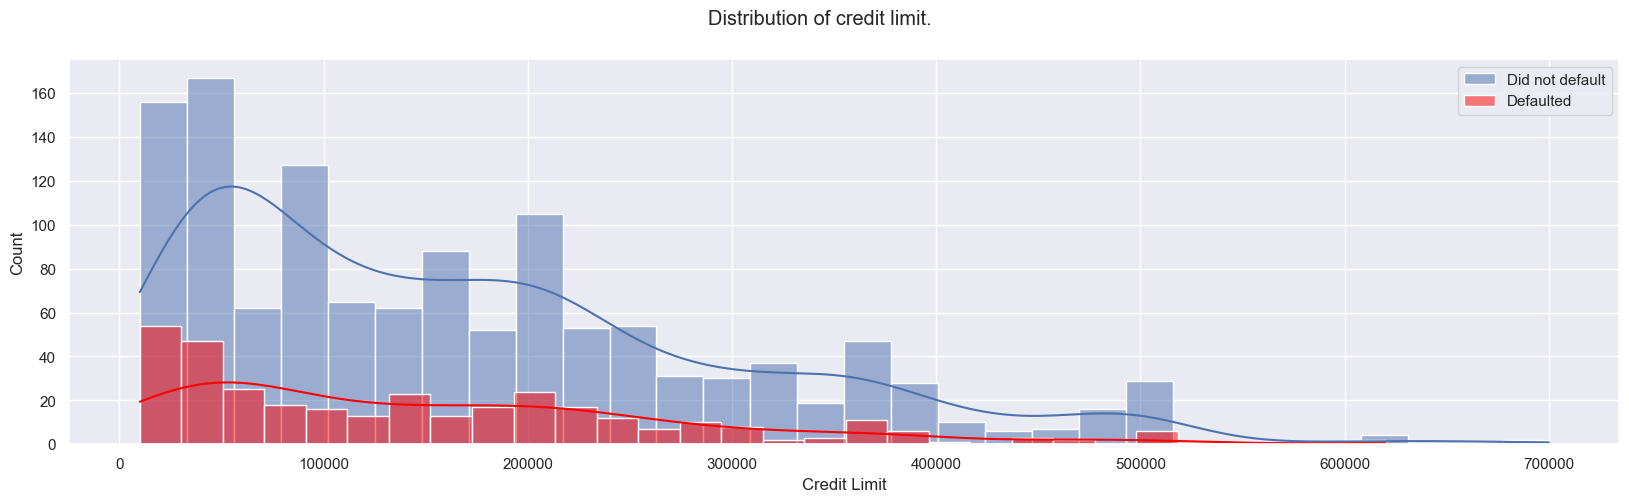

In [9]:
fig, ax = plt.subplots(figsize = (20,5))
fig = sns.histplot(eda_data[eda_data["Default payment next month"] == 0]["Credit Limit"], kde = True, bins = 30, label = "Did not default")
fig2 = sns.histplot(eda_data[eda_data["Default payment next month"] == 1]["Credit Limit"], kde = True, color = "red", bins = 30, label = "Defaulted")
plt.suptitle("Distribution of credit limit.")
ax.legend()
plt.show()

From the above, it is unclear if there is a specific spike in defaulters at a certain credit limit.

Showing the distribution of defaulters based on the age of the customers.

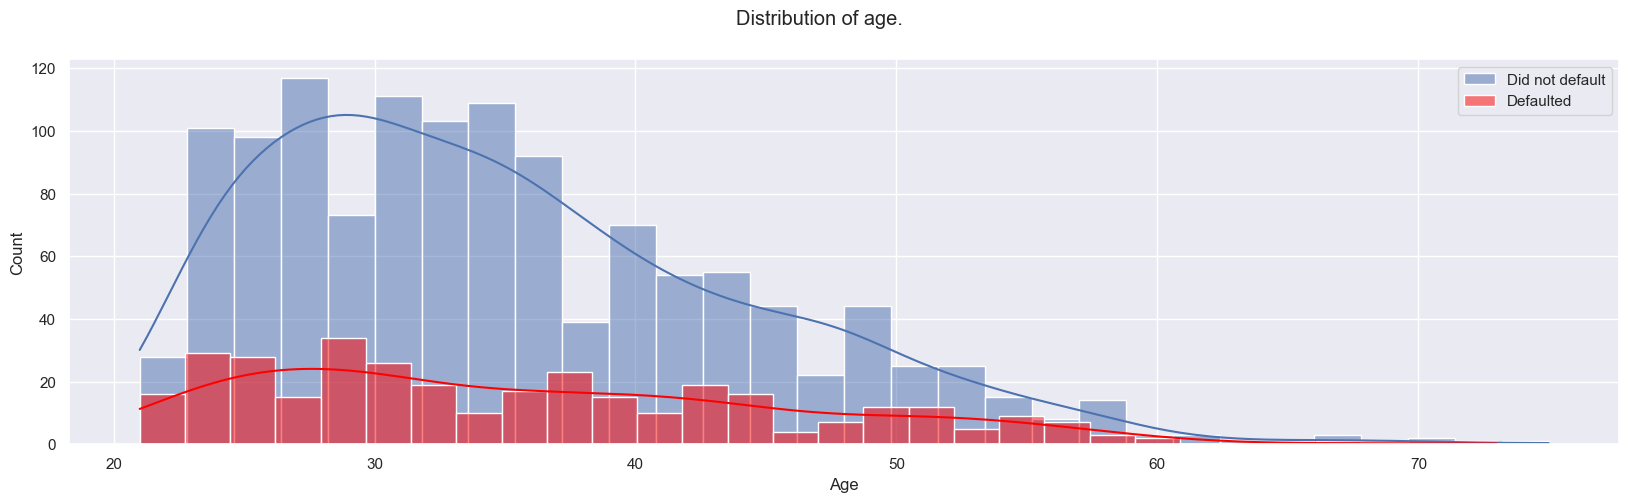

In [10]:
fig, ax = plt.subplots(figsize = (20,5))
fig = sns.histplot(eda_data[eda_data["Default payment next month"] == 0]["Age"], kde = True, bins = 30, label = "Did not default")
fig2 = sns.histplot(eda_data[eda_data["Default payment next month"] == 1]["Age"], kde = True, color = "red", bins = 30, label = "Defaulted")
plt.suptitle("Distribution of age.")
ax.legend()
plt.show()

From the above graph, it is also unclear if there is any spike in defaulters at any specific age group.

Showing the gender distributrion of the customers.

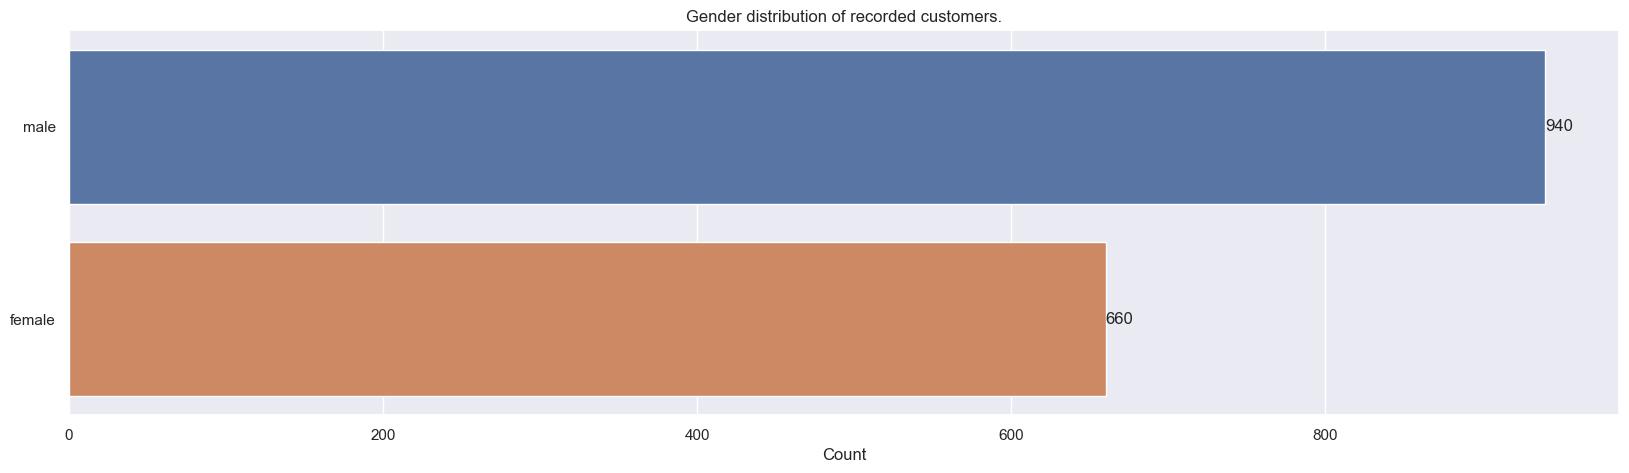

In [11]:
data_count = list(gender_count)
gender_count_dict = dict(male = gender_count[0],female=gender_count[1])
gender_count_dict = pd.DataFrame(data = gender_count_dict, index = ["Count"])
gender_count_dict = gender_count_dict.T
plt.figure(figsize = (20,5))
ax = sns.barplot(data = gender_count_dict, x = "Count", y = gender_count_dict.index)
ax.set(title = "Gender distribution of recorded customers.")
for i in ax.containers:
    ax.bar_label(i,)


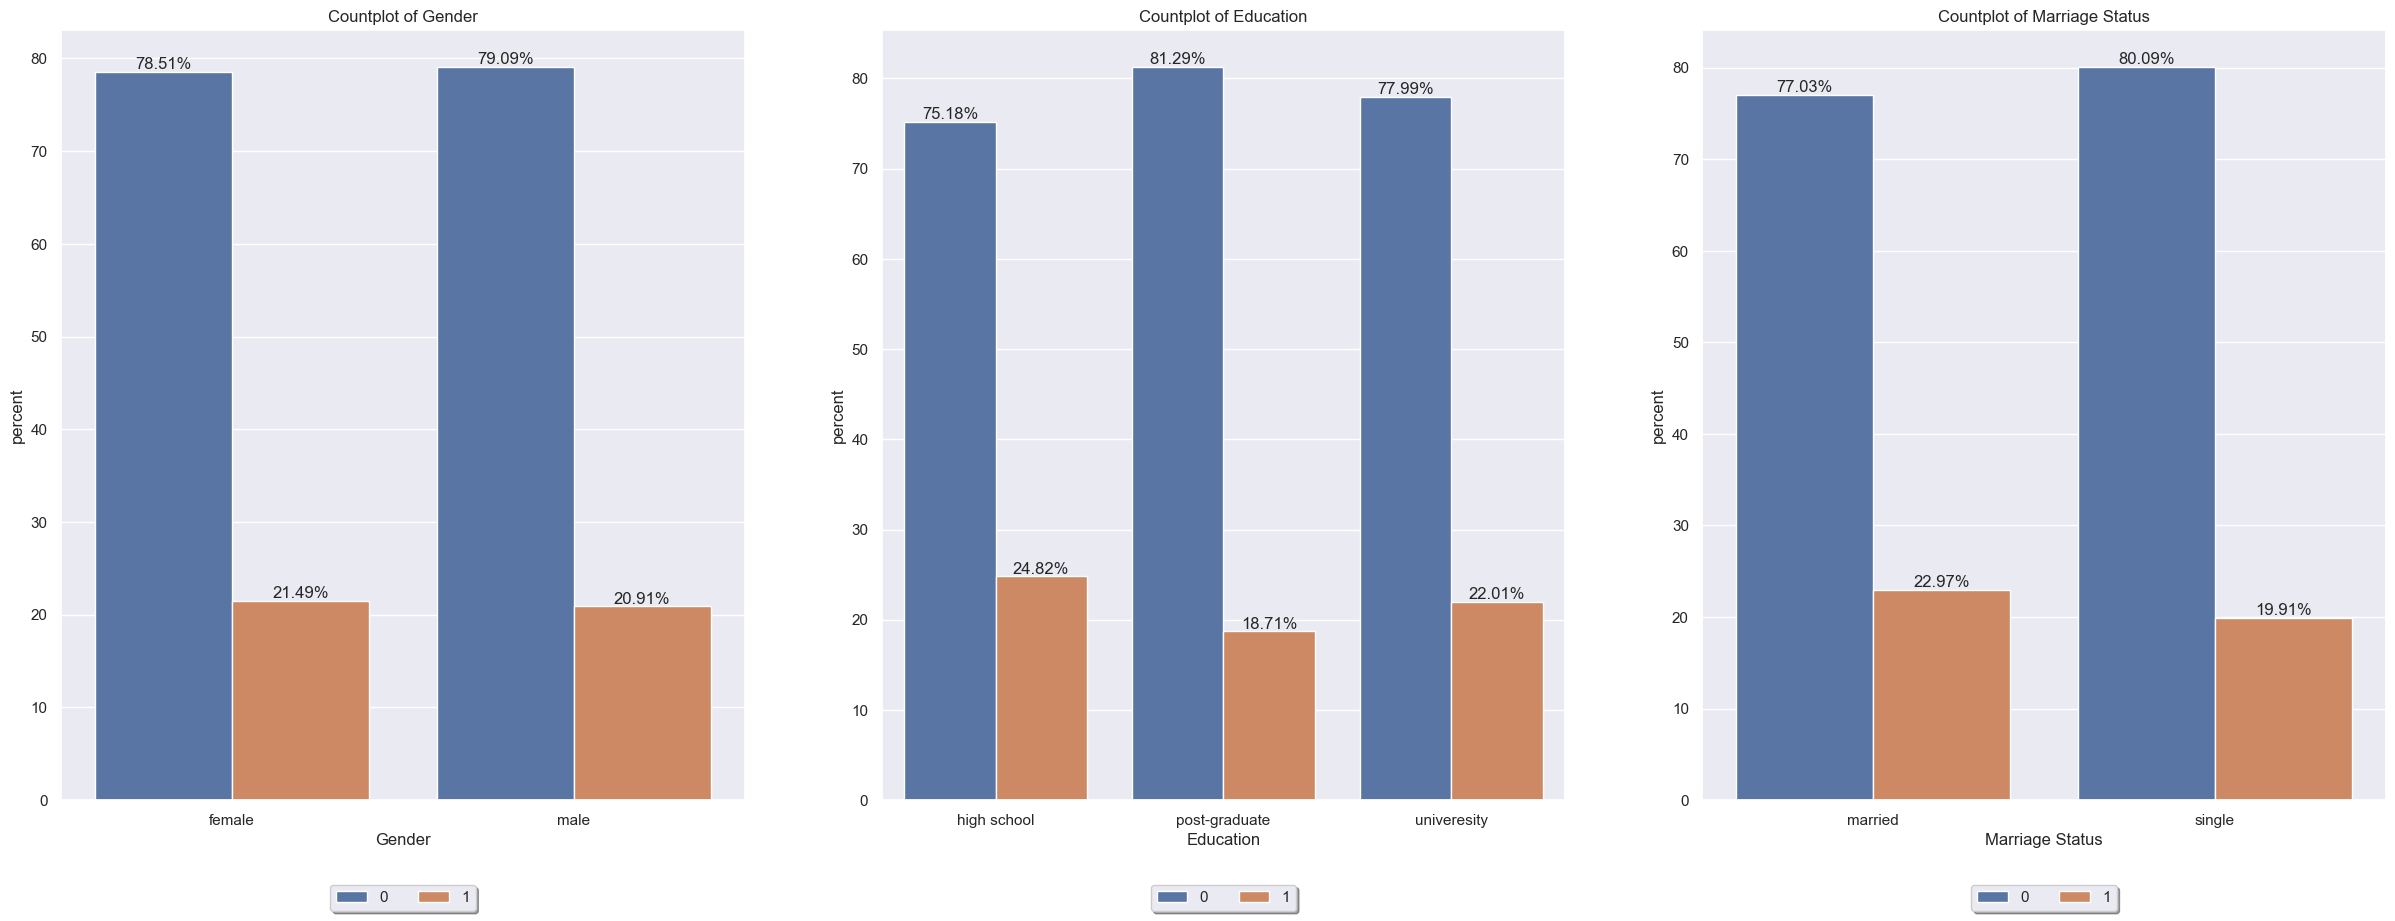

In [12]:
cols_to_display = ["Gender","Education","Marriage Status"]
fig, axs = plt.subplots(1,3, figsize = (30,10))
e = 0
for i in cols_to_display:
    x,y = i, 'Default payment next month'
    subplot_data = (eda_data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index())
    sns.barplot(data=subplot_data, x=x, y='percent', hue=y, ax=axs[e])
    axs[e].legend(loc="upper center", bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=3)
    axs[e].set_title("Countplot of " + i)
    for container in axs[e].containers:
        axs[e].bar_label(container, fmt = '%.2f%%')
    e += 1
    

From the above graph, we can see that gender has a minimal impact on if a person defaults. However, we can see that education levels and marriage status have a effect, with the difference post-graduate education and high school education being 6%, while the marriage status has a difference of 3%.

Showing distribution of the customers who defaulted.

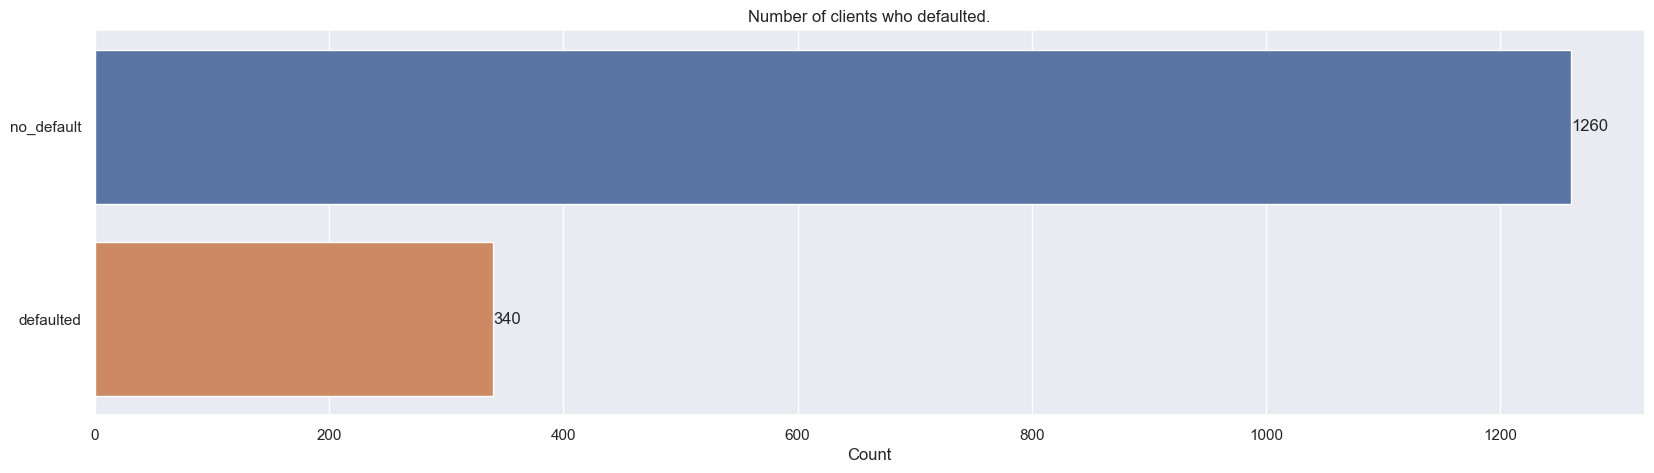

In [13]:
data_count = list(default_count)
# display(gender_count[0])
default_count_dict = dict(no_default = default_count[0], defaulted=default_count[1])
default_count_dict = pd.DataFrame(data = default_count_dict, index = ["Count"])
default_count_dict = default_count_dict.T
plt.figure(figsize = (20,5))
ax = sns.barplot(data = default_count_dict, x = "Count", y = default_count_dict.index)
ax.set(title = "Number of clients who defaulted.")
for i in ax.containers:
    ax.bar_label(i,)

From the above graph, we can see that the dataset is imbalanced, with a significantly larger amount of no_default samples at 1260 compared to defaulted, at 340. <br>
As this is the target variable, it is imperative that that we balance the dataset, as having a imbalance in the target variable will result in poorer model performance. <br>
Hence, we will carry out oversampling to balance the dataset later. 

Correleation plot to show how the variables in the dataset are correlated with each other.

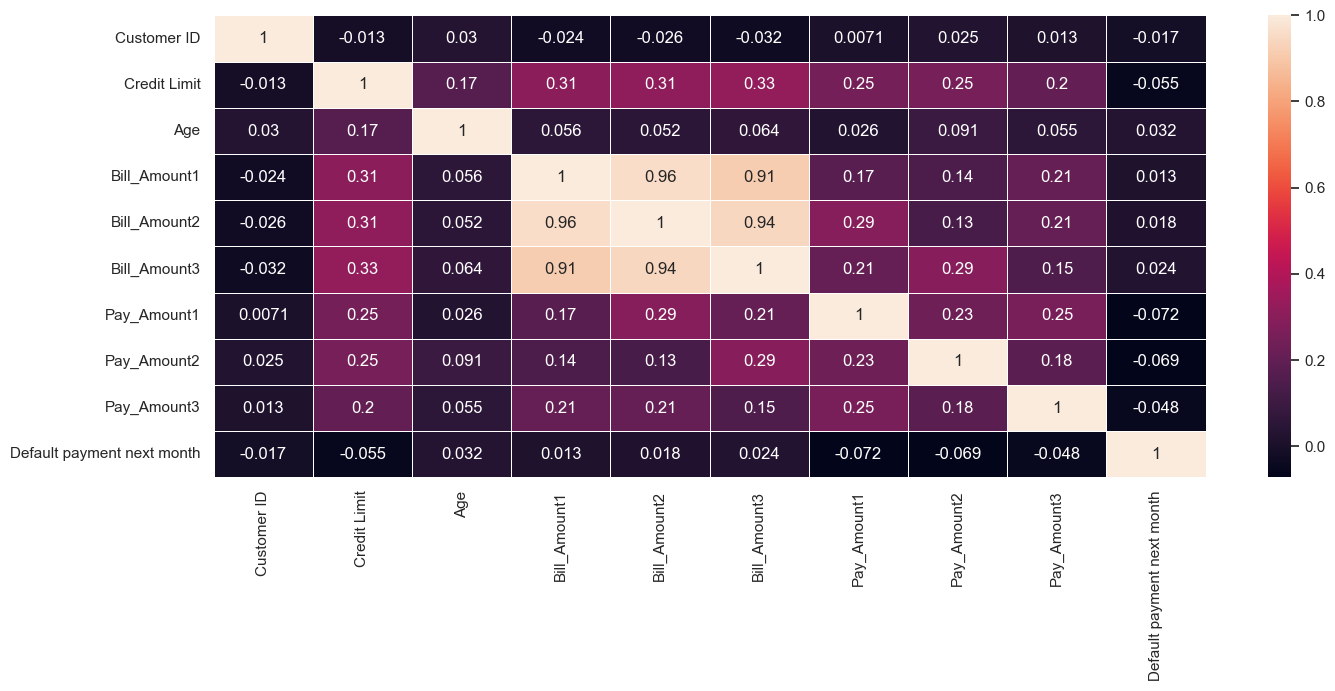

In [14]:
plt.figure(figsize = (16,6))
sns.heatmap(eda_data.corr(), annot = True, linewidths= 0.5)
plt.show()

From the above graph, we can see that the Bill_Amount variables are very highly correlated. This tells us that there is a trend in how much people spend, and we should expect these variables to be quite important in determining if one has defaulted or not.

Generating a pairplot to view the relationships between variables in more detail.


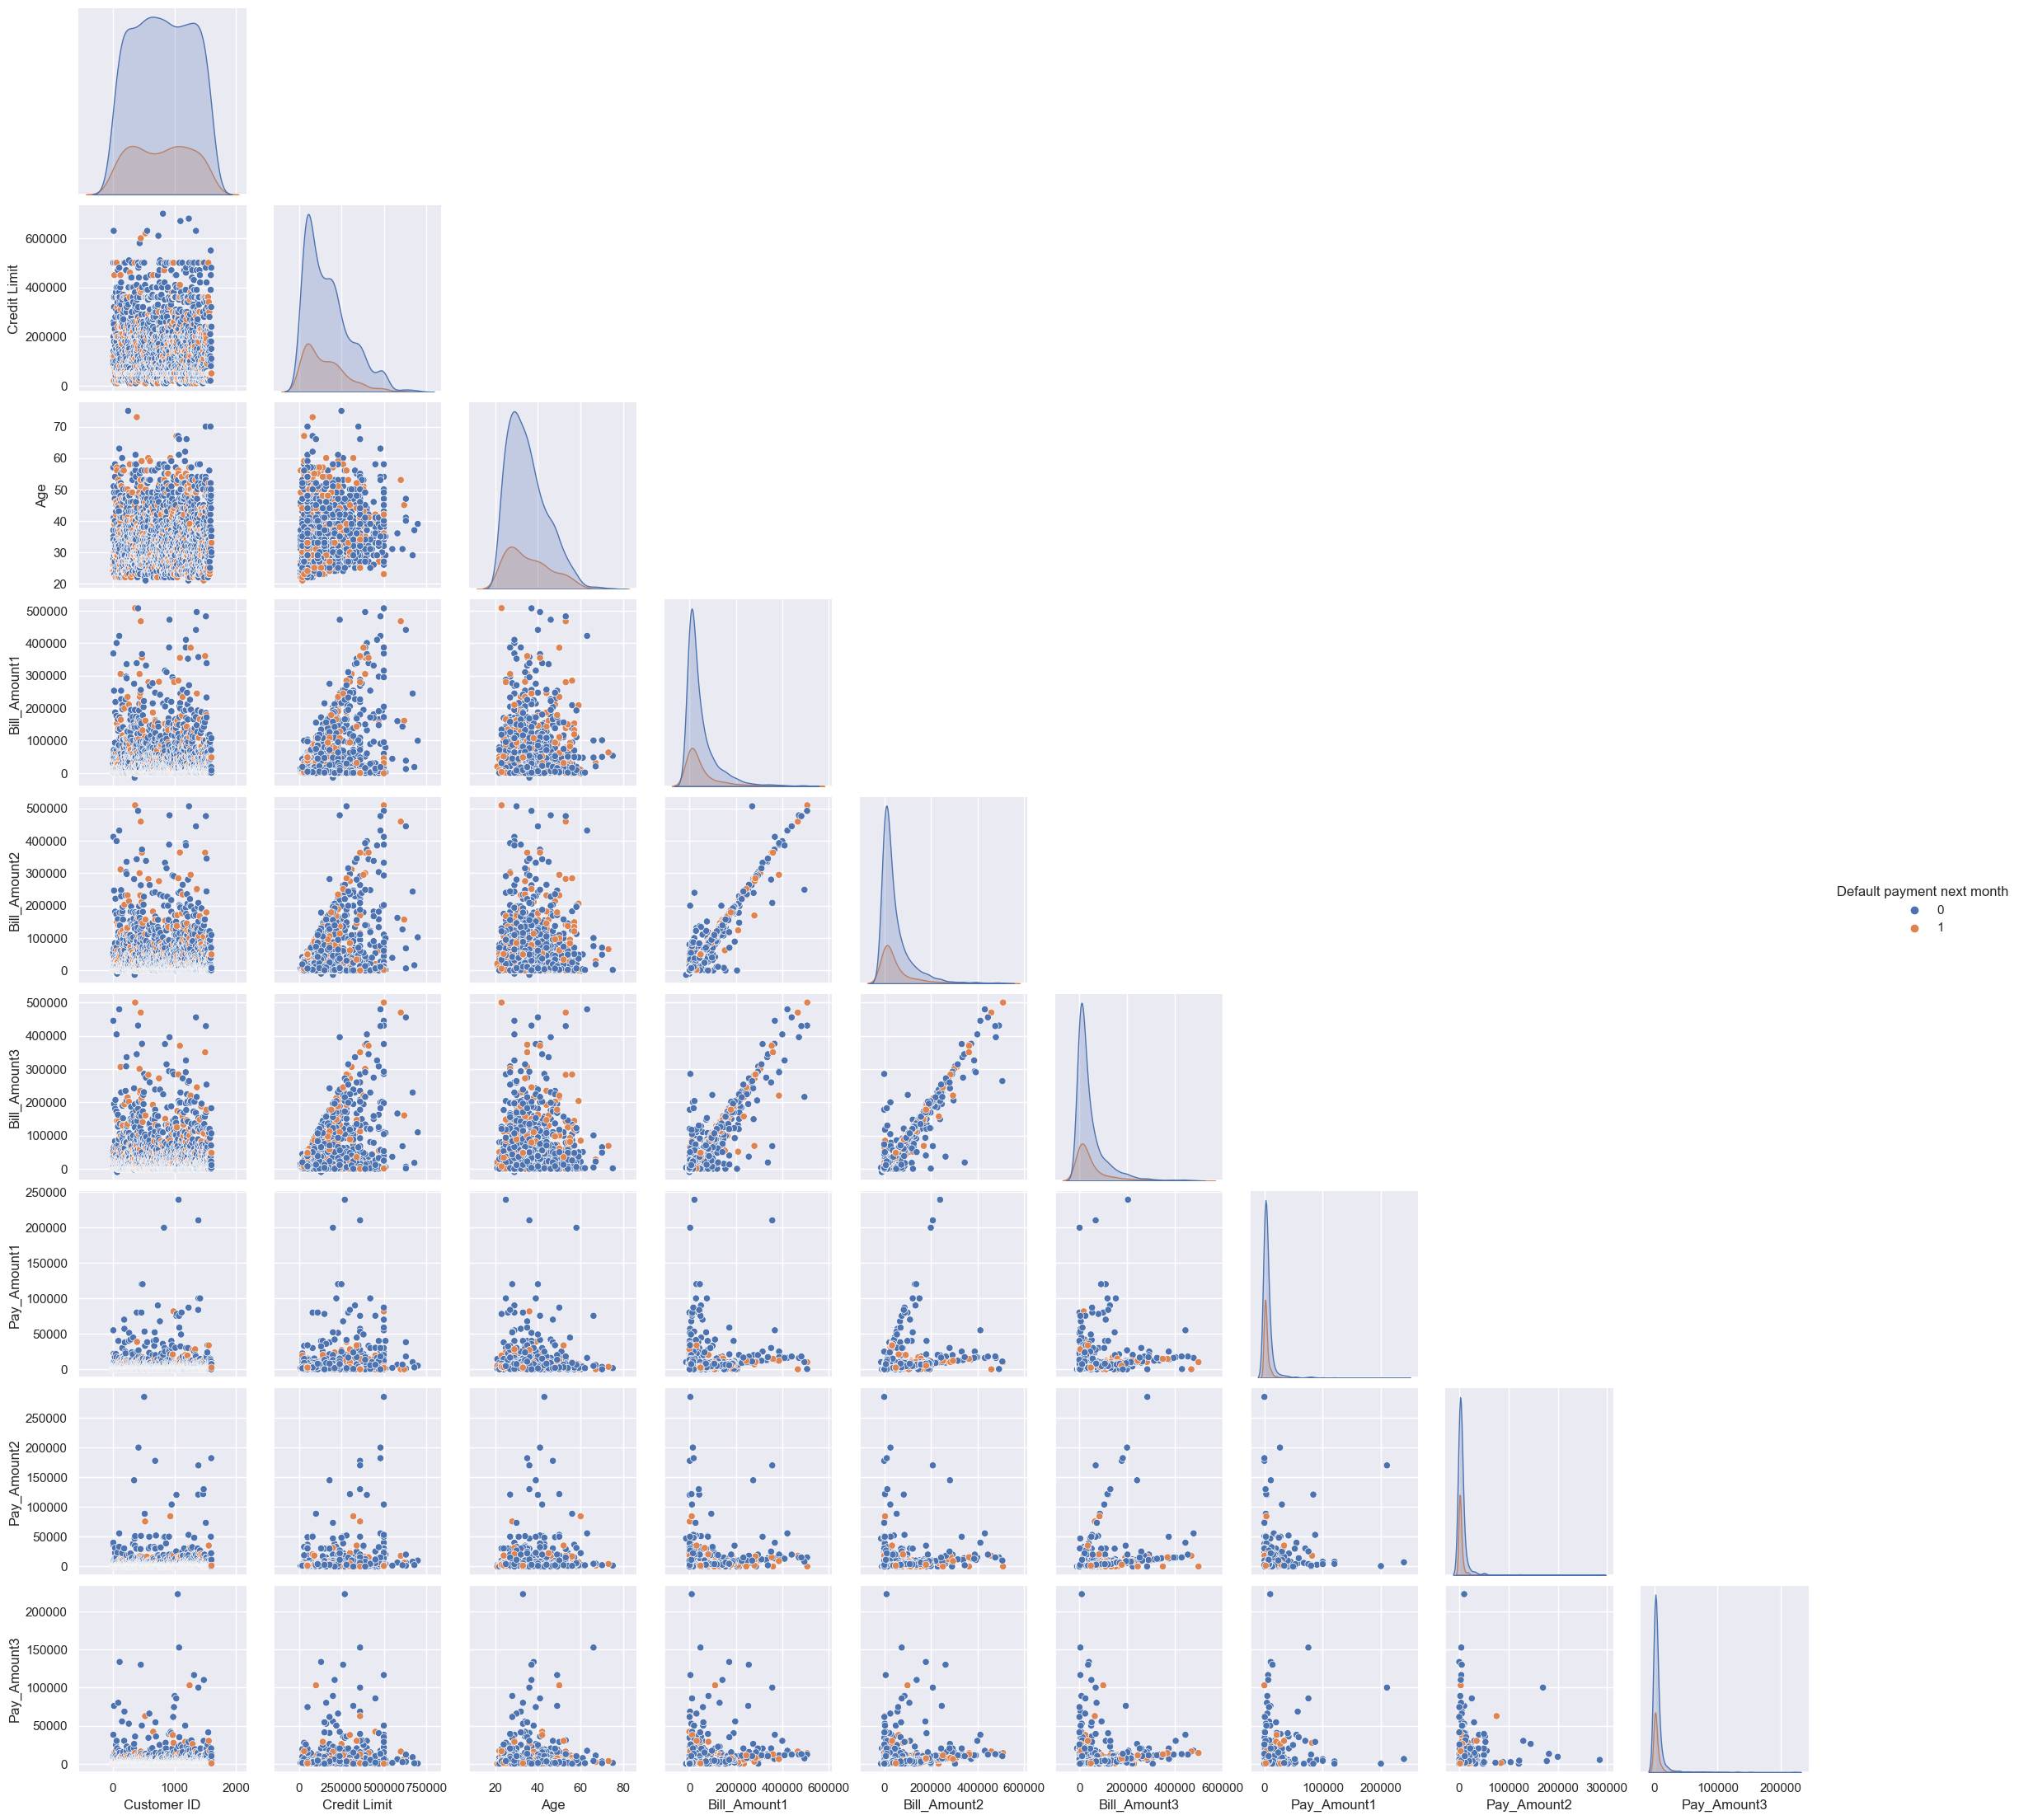

In [15]:
sns.pairplot(eda_data, corner = True, hue = "Default payment next month")
plt.show()

<hr>
<font size = 5>Data Preparation </font>
<hr>

Performing one-hot encoding to prepare the data to train the models.

In [16]:
analysis_data = pd.get_dummies(analysis_data)
display(analysis_data.head())

,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Gender_female,Gender_male,Education_high school,Education_post-graduate,Education_univeresity,Marriage Status_married,Marriage Status_single
0,20000,24,3913,3102,689,0,689,0,1,0,0,0,1,1,0
1,120000,26,2682,1725,2682,0,1000,1000,1,0,0,0,1,0,1
2,90000,34,29239,14027,13559,1518,1500,1000,1,0,0,0,1,0,1
3,50000,37,46990,48233,49291,2000,2019,1200,1,0,0,0,1,1,0
4,50000,57,8617,5670,35835,2000,36681,10000,0,1,0,0,1,1,0


<hr>
<font size = 5>Feature Engineering</font>
<hr>

Obtaining the columns in the dataset.

In [17]:
analysis_data_column = analysis_data.columns
display(analysis_data_column)

Index(['Credit Limit', 'Age', 'Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3',
       'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3', 'Gender_female',
       'Gender_male', 'Education_high school', 'Education_post-graduate',
       'Education_univeresity', 'Marriage Status_married',
       'Marriage Status_single'],
      dtype='object')

Generating new features to train the model on based on existing ones.

In [18]:
analysis_data = pd.DataFrame(data = analysis_data, columns = analysis_data_column)
analysis_data = analysis_data.sort_index()

average_bill = []
average_payment = []
bill_exceed_payment = []
bill_exceed_creditlimit = []
payment_below_bill = []

for i in analysis_data.itertuples():
    exceed_credit_limit_score = 0
    payment_below_bill_score = 0
    average_bill_score = (i[3] + i[4] + i[5])/3
    average_payment_score = (i[6] + i[7] + i[8])/3
    
    if(average_bill_score > average_payment_score):
        bill_exceed_payment.append(1)
    else:
        bill_exceed_payment.append(0)

    if (i[3] > i[1]):
        exceed_credit_limit_score += 1
    if (i[4] > i[1]):
        exceed_credit_limit_score += 1
    if (i[5] > i[1]):
        exceed_credit_limit_score += 1

    if (i[3] > i[6]):
        payment_below_bill_score += 1
    if (i[4] > i[7]):
        payment_below_bill_score += 1
    if (i[5] > i[8]):
        payment_below_bill_score += 1
    
    bill_exceed_creditlimit.append(exceed_credit_limit_score)
    average_bill.append(average_bill_score)
    average_payment.append(average_payment_score)
    payment_below_bill.append(payment_below_bill_score)

analysis_data["average_bill"] = (average_bill)
analysis_data["average_payment"] = (average_payment)
analysis_data["average_bill_exceed_payment"] = (bill_exceed_payment)
analysis_data["bill_exceed_creditlimit"] = (bill_exceed_creditlimit)
analysis_data["payment_below_bill"] = (payment_below_bill)

display(analysis_data)

,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Gender_female,Gender_male,Education_high school,Education_post-graduate,Education_univeresity,Marriage Status_married,Marriage Status_single,average_bill,average_payment,average_bill_exceed_payment,bill_exceed_creditlimit,payment_below_bill
0,20000,24,3913,3102,689,0,689,0,1,0,0,0,1,1,0,2568.000000,229.666667,1,0,3
1,120000,26,2682,1725,2682,0,1000,1000,1,0,0,0,1,0,1,2363.000000,666.666667,1,0,3
2,90000,34,29239,14027,13559,1518,1500,1000,1,0,0,0,1,0,1,18941.666667,1339.333333,1,0,3
3,50000,37,46990,48233,49291,2000,2019,1200,1,0,0,0,1,1,0,48171.333333,1739.666667,1,0,3
4,50000,57,8617,5670,35835,2000,36681,10000,0,1,0,0,1,1,0,16707.333333,16227.000000,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,480000,35,18214,11031,182123,0,182123,12960,1,0,0,0,1,1,0,70456.000000,65027.666667,1,0,2
1596,150000,37,1184,794,2756,0,2772,0,1,0,0,0,1,1,0,1578.000000,924.000000,1,0,2
1597,110000,29,107195,109443,106637,7845,4000,4000,1,0,0,1,0,0,1,107758.333333,5281.666667,1,0,3
1598,240000,30,7744,7284,11234,7305,11263,10018,0,1,0,1,0,0,1,8754.000000,9528.666667,0,0,2


Re-defining the columns in the dataset

In [19]:
analysis_data_column = analysis_data.columns
display(analysis_data_column)

Index(['Credit Limit', 'Age', 'Bill_Amount1', 'Bill_Amount2', 'Bill_Amount3',
       'Pay_Amount1', 'Pay_Amount2', 'Pay_Amount3', 'Gender_female',
       'Gender_male', 'Education_high school', 'Education_post-graduate',
       'Education_univeresity', 'Marriage Status_married',
       'Marriage Status_single', 'average_bill', 'average_payment',
       'average_bill_exceed_payment', 'bill_exceed_creditlimit',
       'payment_below_bill'],
      dtype='object')

Using StandardScaler to standardize the data.

In [20]:
scaler = StandardScaler()
scaler.fit(analysis_data)
analysis_data = scaler.transform(analysis_data)

Splitting the data into training and testing datasets, with a 70/30 split.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(analysis_data, target_data, test_size=0.3, random_state=42)
X_train = pd.DataFrame(data = X_train, columns = analysis_data_column)

<hr>
<font size = 5>Oversampling</font><br>
<font size = 2>Note: We shall carry out oversampling to balance the dataset, and allow for better predictions to be made</font>
<hr>

Viewing the original distribution of the dataset.

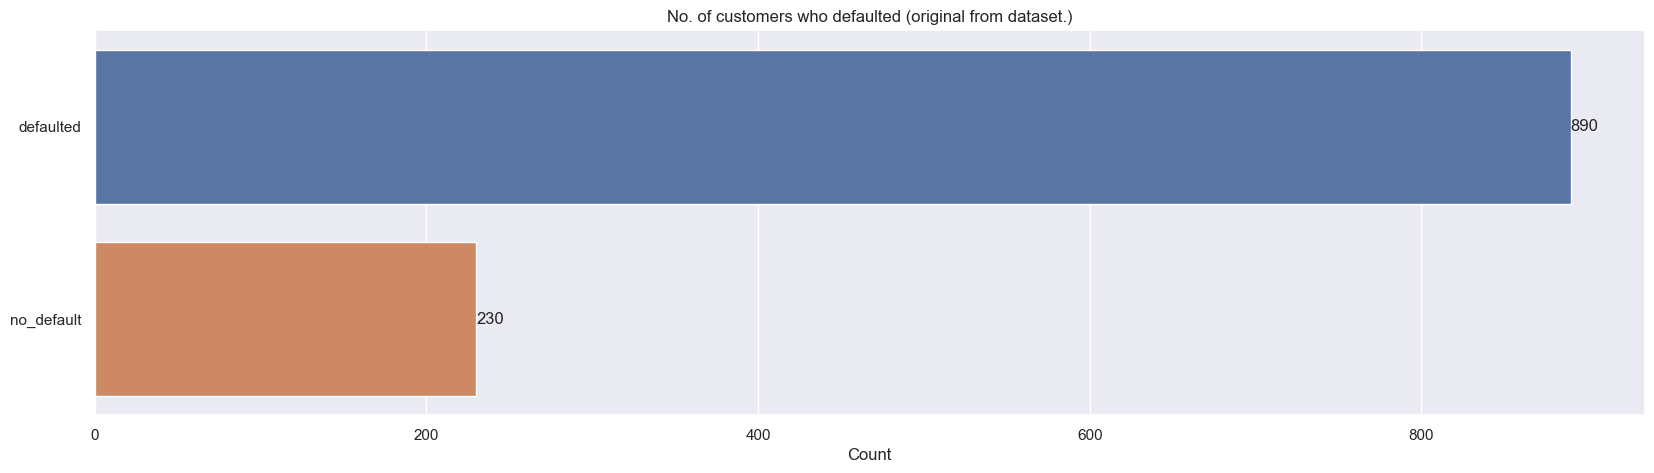

In [22]:
y_train.value_counts() 
initial_count = y_train.value_counts()
initial_count_dict = dict(defaulted = initial_count[0], no_default=initial_count[1])
initial_count_dict = pd.DataFrame(data = initial_count_dict, index = ["Count"])
initial_count_dict = initial_count_dict.T
plt.figure(figsize = (20,5))
ax = sns.barplot(data = initial_count_dict, x = "Count", y = initial_count_dict.index)
ax.set(title = "No. of customers who defaulted (original from dataset.)")
for i in ax.containers:
    ax.bar_label(i,)

Attempting random oversampling to balance the dataset.

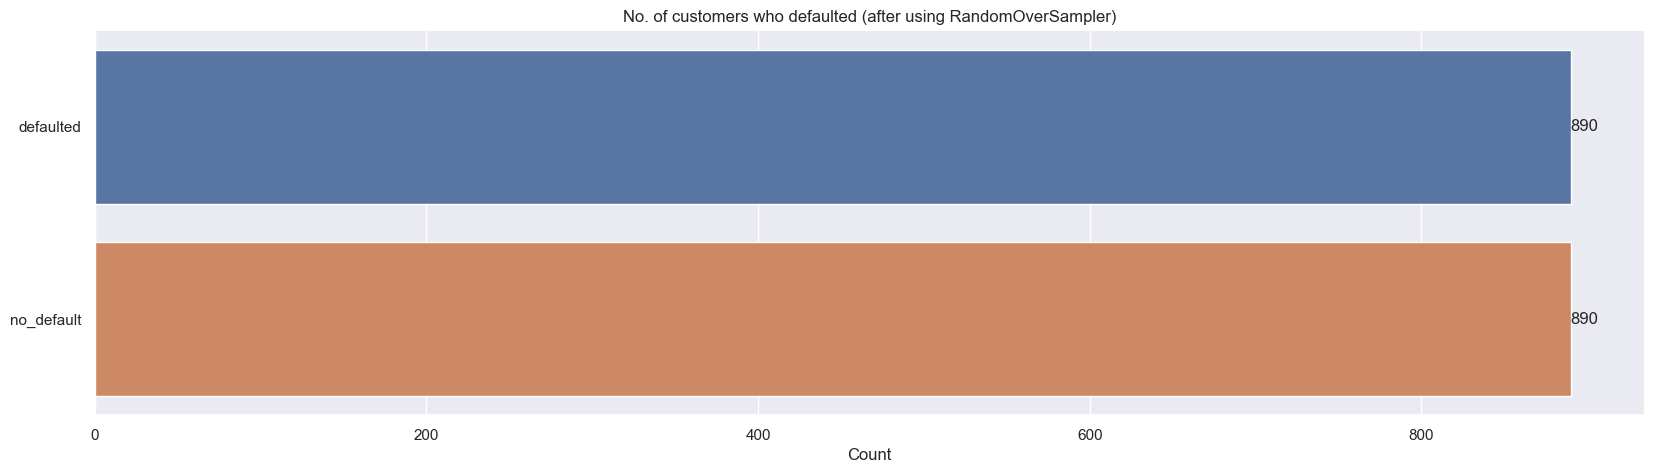

In [23]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

#viewing the results of the analysis
resample_count = y_ros.value_counts()
resample_count_dict = dict(defaulted = resample_count[0], no_default=resample_count[1])
resample_count_dict = pd.DataFrame(data = resample_count_dict, index = ["Count"])
resample_count_dict = resample_count_dict.T
plt.figure(figsize = (20,5))
ax = sns.barplot(data = resample_count_dict, x = "Count", y = resample_count_dict.index)
ax.set(title = "No. of customers who defaulted (after using RandomOverSampler)")
for i in ax.containers:
    ax.bar_label(i,)

Attempting to perform oversampling using the SMOTE algorithm.

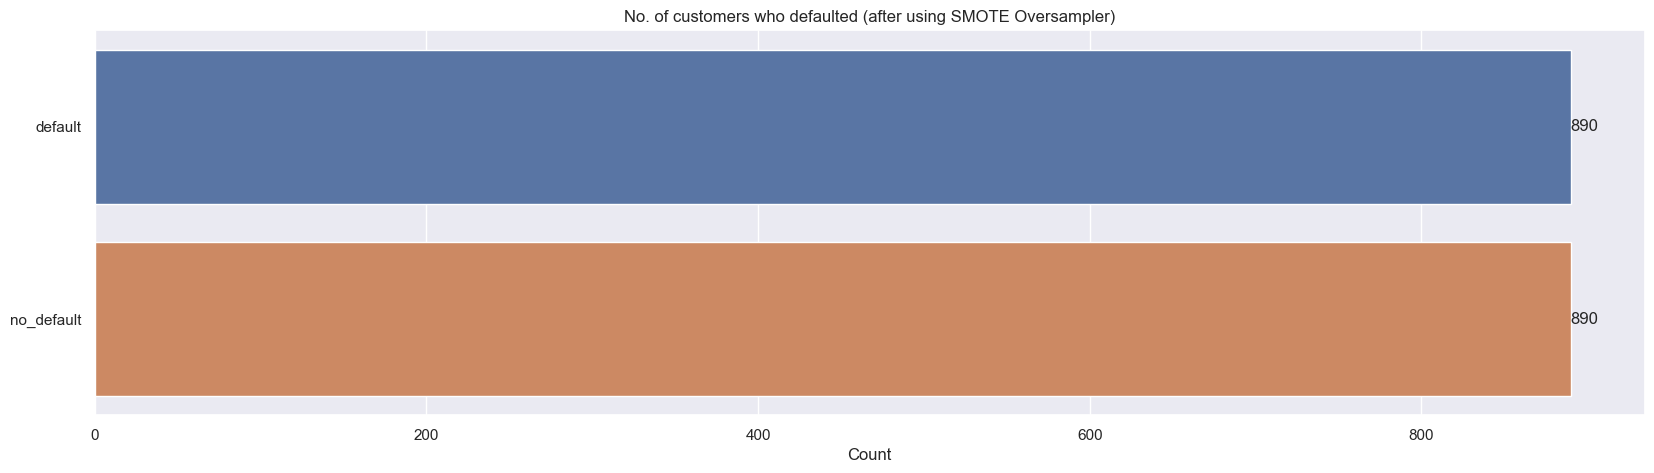

In [24]:
smote_os = SMOTE(random_state=42)
X_smote, y_smote = smote_os.fit_resample(X_train, y_train)
smote_count = y_ros.value_counts()
smote_count = dict(default = smote_count[0], no_default=smote_count[1])
smote_count = pd.DataFrame(data = smote_count, index = ["Count"])
smote_count = smote_count.T
# display(smote_count)
plt.figure(figsize = (20,5))
ax = sns.barplot(data = smote_count, x = "Count", y = smote_count.index)
ax.set(title = "No. of customers who defaulted (after using SMOTE Oversampler)")
for i in ax.containers:
    ax.bar_label(i,)

<hr>
<font size = 5>Initial Modelling</font><br>
<font size = 2>Note: In this segment, we shall verify which method of balancing the dataset will result in the highest accuracy. We will use a KNearestNeighbours model with standardized parameters to verify which is best.
<hr>

Testing accuracy of RandomOverSampling.

c:\Users\Hong Yi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.56      0.66       370
           1       0.27      0.55      0.37       110

    accuracy                           0.56       480
   macro avg       0.54      0.56      0.51       480
weighted avg       0.69      0.56      0.59       480

Accuracy for our testing dataset with tuning is : 55.8333%


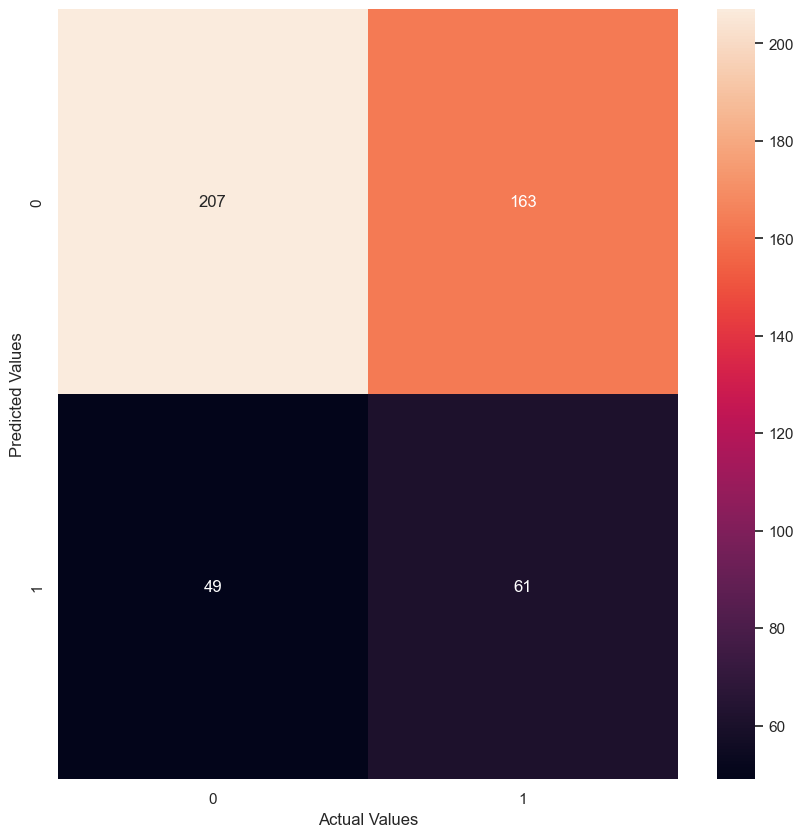

In [25]:
ros_knn = KNeighborsClassifier(n_jobs = -1, n_neighbors= 15)
ros_knn.fit(X_ros, y_ros)
y_ros_pred = ros_knn.predict(X_test)
test_accuracy=accuracy_score(y_test, y_ros_pred)*100

fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(confusion_matrix(y_test, y_ros_pred), annot= True, fmt = "g", ax = ax)
print(metrics.classification_report(y_test,  y_ros_pred))

ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")

print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )

Testing accuracy of SMOTE Oversampling.

c:\Users\Hong Yi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.49      0.61       370
           1       0.28      0.65      0.39       110

    accuracy                           0.53       480
   macro avg       0.55      0.57      0.50       480
weighted avg       0.70      0.53      0.56       480

Accuracy for our testing dataset with tuning is : 52.7083%


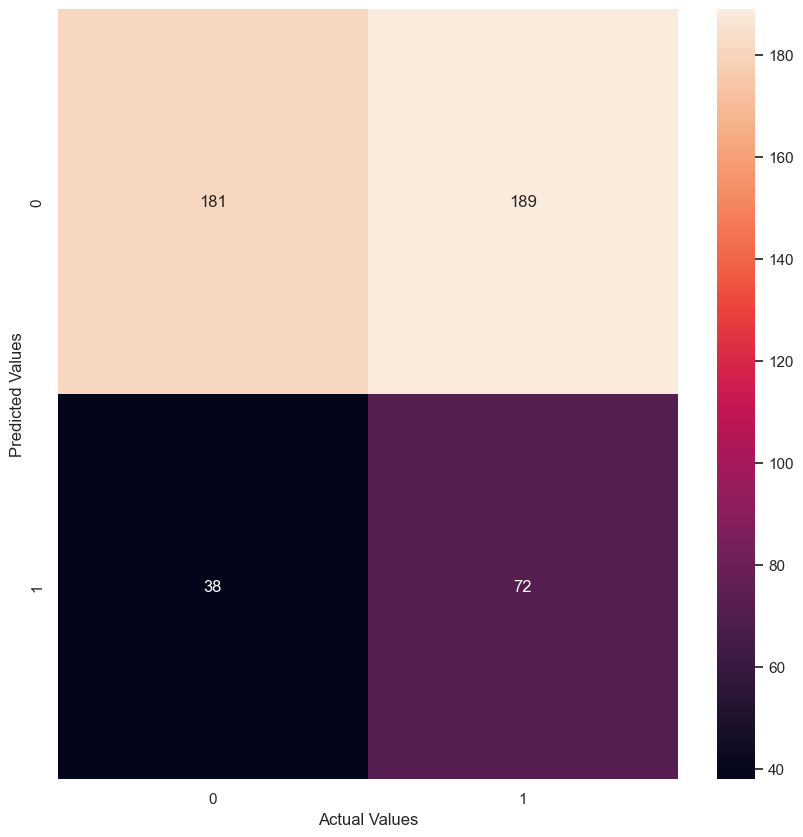

In [26]:
smote_knn = KNeighborsClassifier(n_jobs = -1, n_neighbors= 15)
smote_knn.fit(X_smote, y_smote)
y_smote_pred = smote_knn.predict(X_test)
test_accuracy=accuracy_score(y_test, y_smote_pred)*100

fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(confusion_matrix(y_test, y_smote_pred), annot= True, fmt = "g", ax = ax)
print(metrics.classification_report(y_test,  y_smote_pred))
ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")
print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )

In [27]:
X_train = X_ros
y_train = y_ros

<hr>
<font size = 5>Model Selection.</font><br>
<hr>
<font size = 3>Here, I will determine which model is the best for the bank to use, by comparing each model to each other. Then, I will go ahead and carry out hypertuning to obtain the best parameters for the model. To determine which model is the best, I will use the f1_score scoring parameter.</font>


I decide to use f1_score as the primary method, as it is calculated as the harmonic mean between the precision and recall scores. This is the best for the bank, as while it's main goal is risk mitigation, it also has to ensure that it does not wrongly classify people as defaulters. I use the f1_score instead of simply averaging the two, as the bank has to strike a balance between the false negatives and false positives. The equation to generate the f1_score is as follows.

$$
\text{F1 Score} = \frac{2 \times \text{True Positives}}{2 \times \text{True Positives} + \text{False Positives} + \text{False Negatives}}
$$
Where:
- True Positives represent the number of correctly predicted positive samples.
- False Positives represent the number of incorrectly predicted positive samples.
- False Negatives represent the number of incorrectly predicted negative samples.



Defining a model to plot learning curves.

In [28]:
def plot_learning_curve(model_name, model, X, y, train_sizes, cv, ax, scoring = None):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes=train_sizes, cv=cv, scoring = scoring)

    # calculating mean and standard deviation of train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # plotting learning curve
    plt.figure(figsize=(10, 6))
    ax.plot(train_sizes, train_mean, label='Training Score', color='blue', marker = '.')
    ax.plot(train_sizes, test_mean, label='Validation Score', color='red', marker = '.')

    # adding model-specific details to plot
    ax.set_title(f'Learning Curve for {model_name}')
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best')
    ax.grid(True)

f1_scorer = make_scorer(f1_score, zero_division = 1)

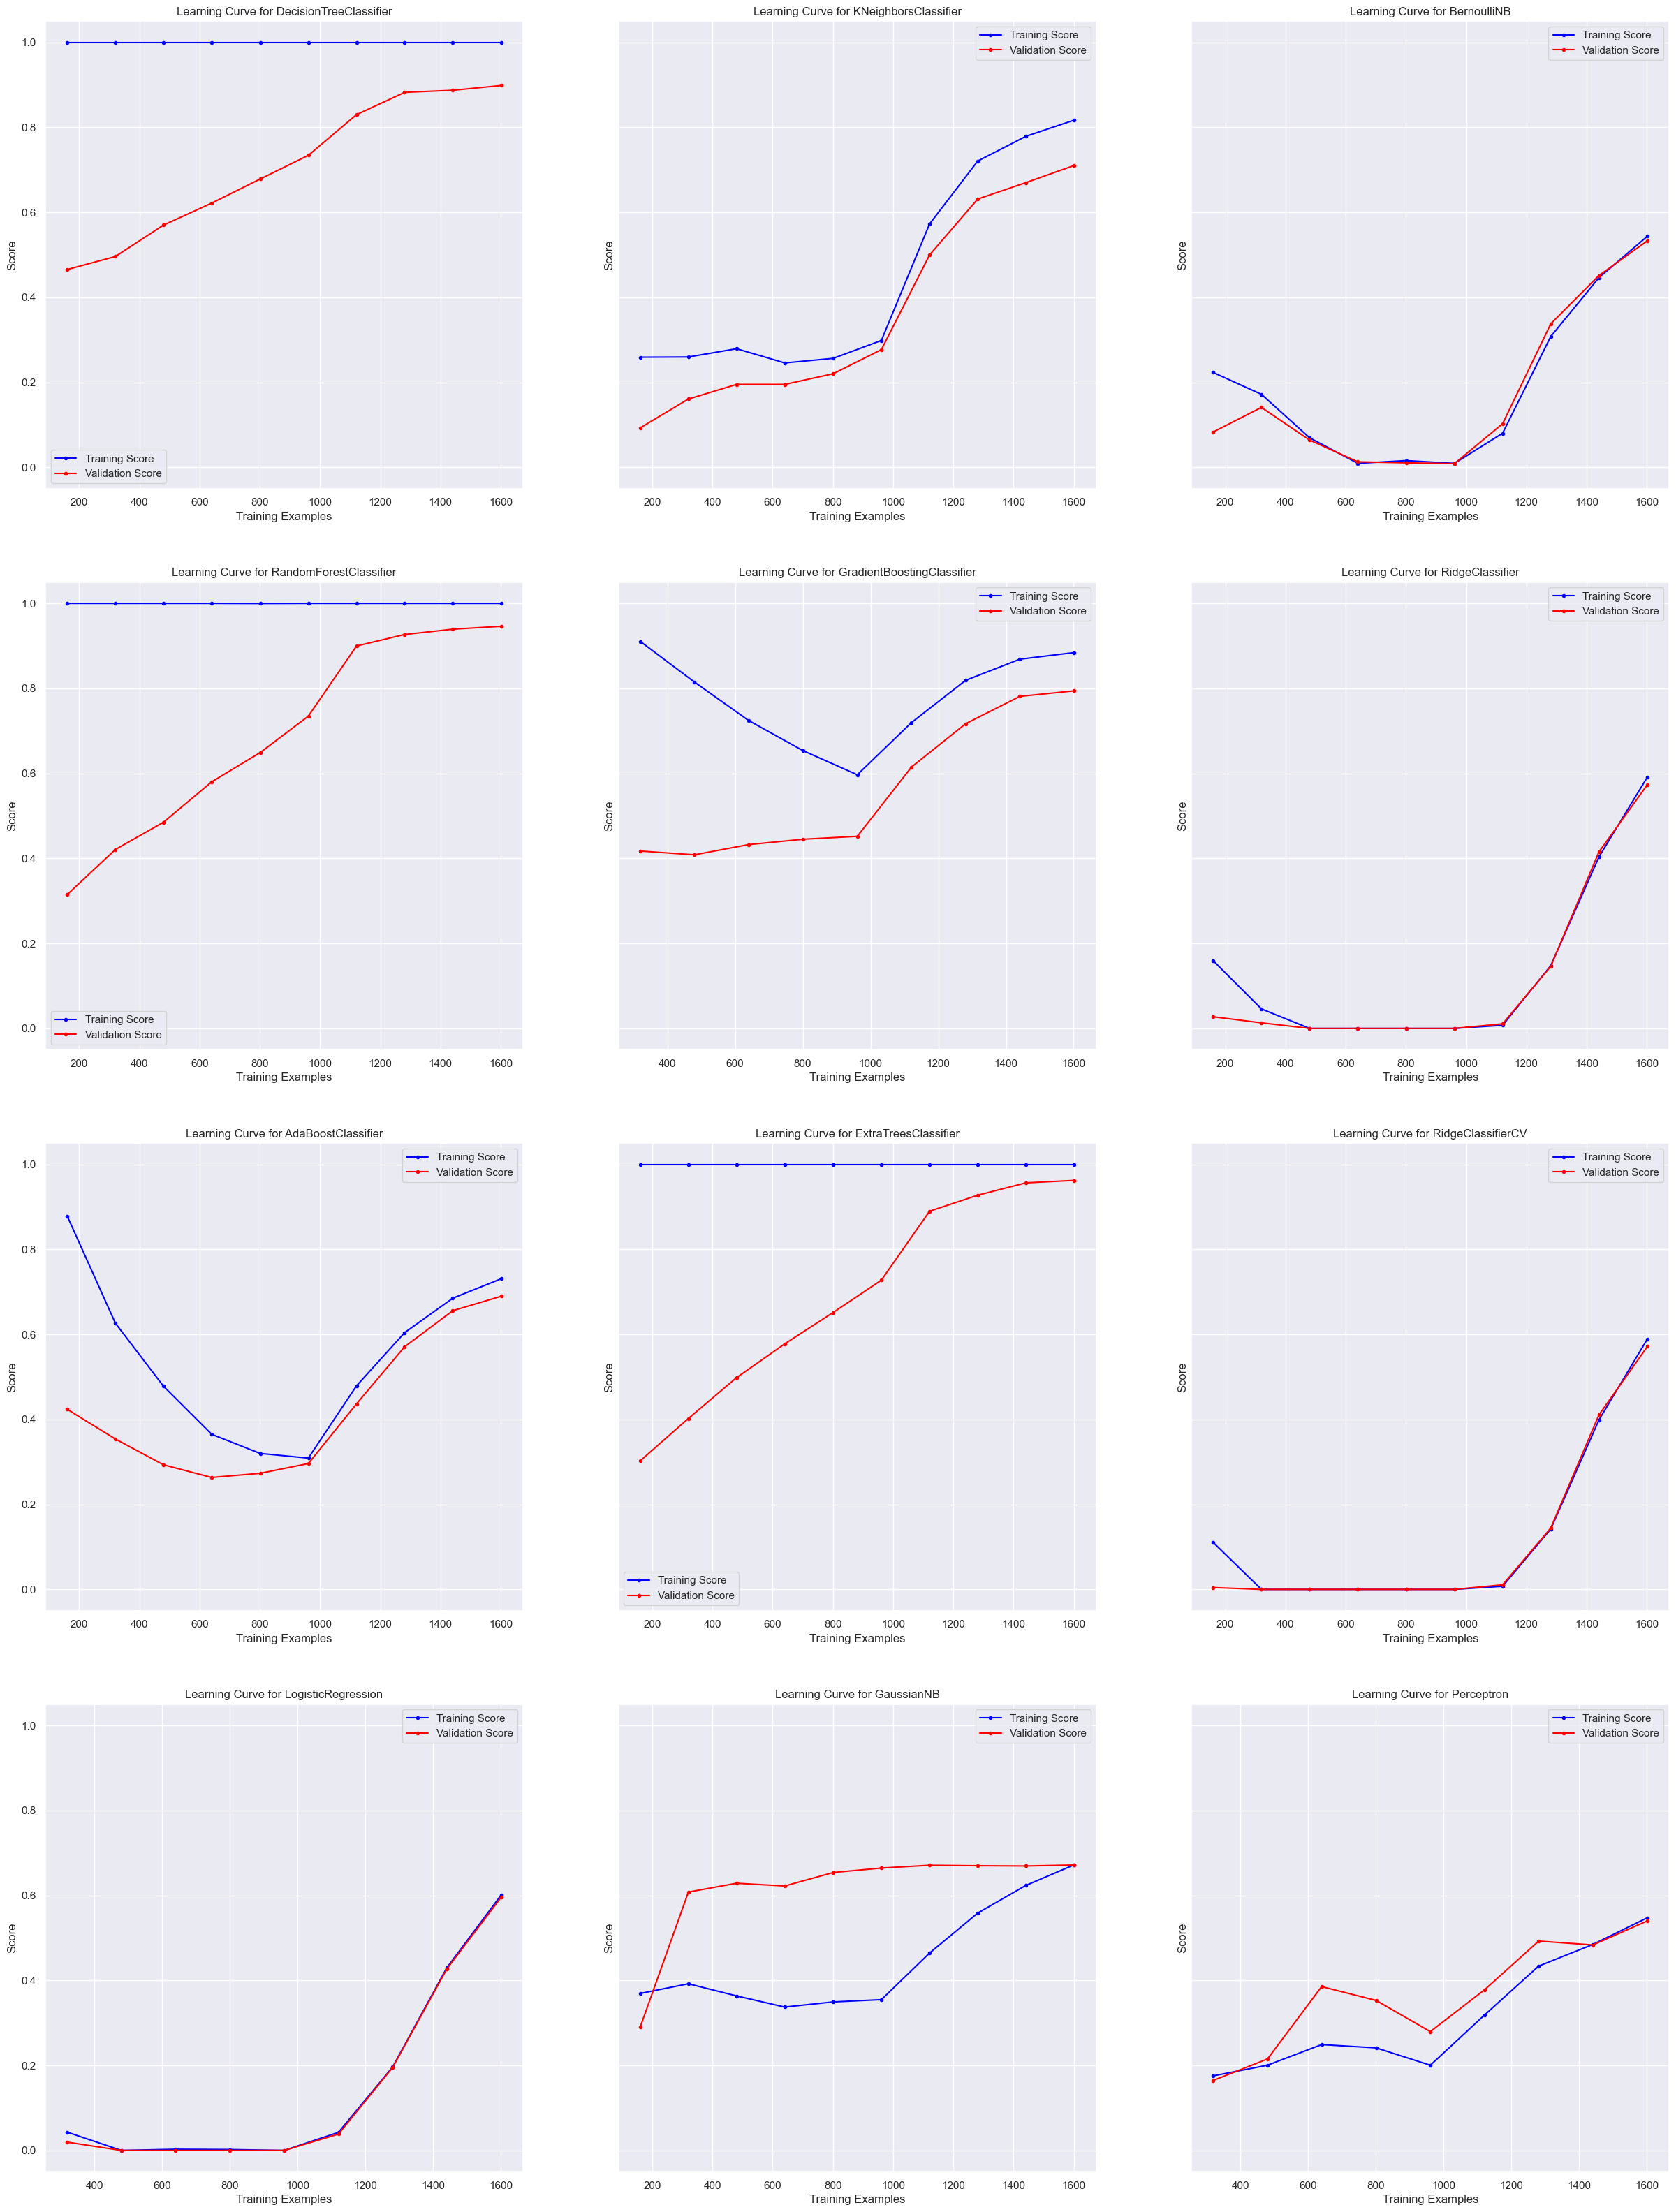

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

,fit_time,score_time,test_accuracy,test_roc_auc,test_f1,test_average_precision
model,,,,,,
ExtraTreesClassifier,0.357727,0.051483,0.962921,0.992558,0.963479,0.994902
RandomForestClassifier,0.459496,0.040288,0.945506,0.991011,0.947553,0.992448
DecisionTreeClassifier,0.013176,0.005364,0.883708,0.883708,0.894945,0.816723
GradientBoostingClassifier,0.640061,0.009226,0.791011,0.872333,0.794987,0.868528
KNeighborsClassifier,0.001974,0.022664,0.666854,0.752575,0.710496,0.703617
AdaBoostClassifier,0.222133,0.033441,0.692697,0.760371,0.689904,0.751422
GaussianNB,0.002094,0.004177,0.535393,0.588335,0.671633,0.584701
LogisticRegression,0.011104,0.005471,0.594944,0.617043,0.596241,0.600577
RidgeClassifier,0.002619,0.004099,0.579213,0.606956,0.573456,0.593709


In [29]:
model_score_list = []
cv_model_score_df = pd.DataFrame()
scoring = ['accuracy','roc_auc','f1', 'average_precision']

#selecting plots to use
models = [
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("LogisticRegression", LogisticRegression()),
    ("KNeighborsClassifier", KNeighborsClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("ExtraTreesClassifier", ExtraTreesClassifier()),
    ("GaussianNB", GaussianNB()),
    ("BernoulliNB", BernoulliNB()),
    ("RidgeClassifier", RidgeClassifier()),
    ("RidgeClassifierCV", RidgeClassifierCV()),
    ("Perceptron", Perceptron())
]

no_x_plot = 0
no_y_plot = 0
fig, ax = plt.subplots(4, 3, figsize=(30, 40), sharey = True)

#for loop to train all models and plot
for model_name, model in models:
    f1_scores = 0
    model.fit(X_train, y_train)
    model_cv_results = pd.DataFrame(data = cross_validate(model, X_train, y_train, cv = 10, scoring = scoring))
    model_cv_results = pd.DataFrame(model_cv_results.mean(axis = 0)).T
    model_cv_results["model"] = model_name
    cv_model_score_df = cv_model_score_df.append(model_cv_results)
    plot_learning_curve(model_name, model, X_train, y_train, np.linspace(0.1, 1.0, 10), 10, ax = ax[models.index((model_name, model)) % 4, models.index((model_name, model)) // 4], scoring = f1_scorer)

cv_model_score_df = cv_model_score_df.set_index(["model"])

plt.show()
display(cv_model_score_df.sort_values(by = 'test_f1', ascending = False).style.background_gradient(cmap = "flare"))
# display(cv_model_score_df)

Since the ExtraTreesClassifier and RandomForestClassifier have high f1 scores, we will then focus on those two models, and hypertune them to allow the best predictions to be made. <br>
Even though they take longer to fit and score compared to the other models, they have a much higher accuracy score compared to the other models, making the trade-off worthwhile. <br>
In addition, we can also see from the learning curves that the models are not overfitted or underfitted.

<hr>
<font size = 5>Hypertuning Selected Models</font>
<hr>

In this section, we shall use GridSearchCV to identify which parameters allow the model to perform at it's best.

Hypertuning the ExtraTreesClassifier model with its given parameters, and identifying which parameters give the best f1_score.

In [30]:
etc_grid = dict(n_estimators=list(range(1,35)), criterion = ["gini",'entropy'], min_samples_split = np.linspace(2,11,10, dtype = int))
etc = ExtraTreesClassifier()

etc_grid_search = GridSearchCV(etc, param_grid= etc_grid, n_jobs= -1, verbose = 1, error_score = 'raise', scoring = ['accuracy', 'f1'], refit = 'f1')
etc_search = etc_grid_search.fit(X_train, y_train)

print(etc_search.best_params_)

etc_cv_results = pd.DataFrame(etc_search.cv_results_)
best_model_results = pd.DataFrame(etc_cv_results.loc[etc_search.best_index_])
display(best_model_results)

accuracy = etc_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy))

Fitting 5 folds for each of 680 candidates, totalling 3400 fits
{'criterion': 'entropy', 'min_samples_split': 3, 'n_estimators': 32}


,405
mean_fit_time,0.195056
std_fit_time,0.046479
mean_score_time,0.021345
std_score_time,0.013704
param_criterion,entropy
param_min_samples_split,3
param_n_estimators,32
params,"{'criterion': 'entropy', 'min_samples_split': ..."
split0_test_accuracy,0.949438
split1_test_accuracy,0.955056


Accuracy for our training dataset with tuning is : 96.0307%


Hypertuning the RandomForestClassifier model with its given parameters, and identifying which parameters give the best f1_score.

In [31]:
n_est_arr = list(np.arange(1,35))
for i in list(np.arange(35,150,5)):n_est_arr.append(i)

param_grid = dict(n_estimators= n_est_arr, max_depth= np.arange(1,10,1), max_features =['sqrt', 'log2'])
rfc = RandomForestClassifier(n_jobs = -1)
rfc_grid = GridSearchCV(rfc, param_grid = param_grid, return_train_score=False, verbose=1, n_jobs= -1, error_score = 'raise', scoring = ['accuracy', 'f1'], refit = 'f1')
rfc_search = rfc_grid.fit(X_train, y_train)

rfc_cv_results = pd.DataFrame(rfc_search.cv_results_)
best_model_results = pd.DataFrame(rfc_cv_results.loc[rfc_search.best_index_])
display(best_model_results)

print(rfc_search.best_params_)
accuracy = rfc_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy) )

Fitting 5 folds for each of 1026 candidates, totalling 5130 fits


,1023
mean_fit_time,0.52444
std_fit_time,0.056434
mean_score_time,0.094563
std_score_time,0.063583
param_max_depth,9
param_max_features,log2
param_n_estimators,135
params,"{'max_depth': 9, 'max_features': 'log2', 'n_es..."
split0_test_accuracy,0.873596
split1_test_accuracy,0.893258


{'max_depth': 9, 'max_features': 'log2', 'n_estimators': 135}
Accuracy for our training dataset with tuning is : 89.7220%


<hr>
<font size = 5 >Evaluating the tuned models</font>
<hr>

Now, we shall test the model on unseen data, or the test data. This will allow us to see which model is better, and more accurate in predicting if a client will default. But first, we shall have train a dummy baseline model to comapare our hypertuned models to.

In [32]:
dummy_model = DummyClassifier(strategy ='uniform')
dummy_model.fit(X_train, y_train)
dummy_y_test_hat = dummy_model.predict(X_test)

accuracy = accuracy_score(y_test, dummy_y_test_hat)
dummy_f1_score = f1_score(y_test, dummy_y_test_hat, average= 'weighted')
print(metrics.classification_report(y_test,  dummy_y_test_hat))
print("Accuracy for our training dataset using the dummy model is : {:.4f}%".format(accuracy*100) )
print("f1_Score for our training dataset using the dummy model is : {:.4f}".format(dummy_f1_score))

              precision    recall  f1-score   support

           0       0.77      0.53      0.63       370
           1       0.23      0.46      0.31       110

    accuracy                           0.52       480
   macro avg       0.50      0.50      0.47       480
weighted avg       0.65      0.52      0.56       480

Accuracy for our training dataset using the dummy model is : 51.6667%
f1_Score for our training dataset using the dummy model is : 0.5551


In [33]:
etc_tuned = ExtraTreesClassifier(n_estimators = etc_search.best_params_['n_estimators'], criterion = etc_search.best_params_["criterion"], min_samples_split = etc_search.best_params_["min_samples_split"])
etc_tuned.fit(X_train, y_train)
etc_y_test = etc_tuned.predict(X_test)

test_accuracy = accuracy_score(y_test, etc_y_test) * 100
etc_f1_score = f1_score(y_test, etc_y_test, average = 'weighted')
accuracy = accuracy_score(y_test, etc_y_test)

print(classification_report(y_test, etc_y_test, zero_division= 0))
print("Accuracy for our training dataset using the tuned ExtraTreeClassifier model is : {:.4f}%".format(accuracy*100) )
print(f"The f1_score for the tuned ExtraTreeClassifier is {etc_f1_score:.4f}")

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       370
           1       0.29      0.05      0.08       110

    accuracy                           0.76       480
   macro avg       0.53      0.51      0.47       480
weighted avg       0.66      0.76      0.68       480

Accuracy for our training dataset using the tuned ExtraTreeClassifier model is : 75.6250%
The f1_score for the tuned ExtraTreeClassifier is 0.6806


c:\Users\Hong Yi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


In [34]:
rfc_tuned = RandomForestClassifier(max_depth = rfc_search.best_params_['max_depth'], n_estimators = rfc_search.best_params_["n_estimators"], max_features= rfc_search.best_params_['max_features'])
rfc_tuned.fit(X_train, y_train)
rfc_y_test = rfc_tuned.predict(X_test)

test_accuracy = accuracy_score(y_test, rfc_y_test) * 100
rfc_f1_score = f1_score(y_test, rfc_y_test, average = 'weighted')
accuracy = accuracy_score(y_test, rfc_y_test)

print(classification_report(y_test, rfc_y_test, zero_division= 0))
print("Accuracy for our training dataset using the tuned RandomForestClassifier model is : {:.4f}%".format(accuracy*100) )
print(f"The f1_score for the tuned RandomForestClassifier is {rfc_f1_score:.4f}")

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       370
           1       0.36      0.22      0.27       110

    accuracy                           0.73       480
   macro avg       0.58      0.55      0.55       480
weighted avg       0.69      0.73      0.71       480

Accuracy for our training dataset using the tuned RandomForestClassifier model is : 73.3333%
The f1_score for the tuned RandomForestClassifier is 0.7075


c:\Users\Hong Yi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Comparing the confusion matrices of both models.

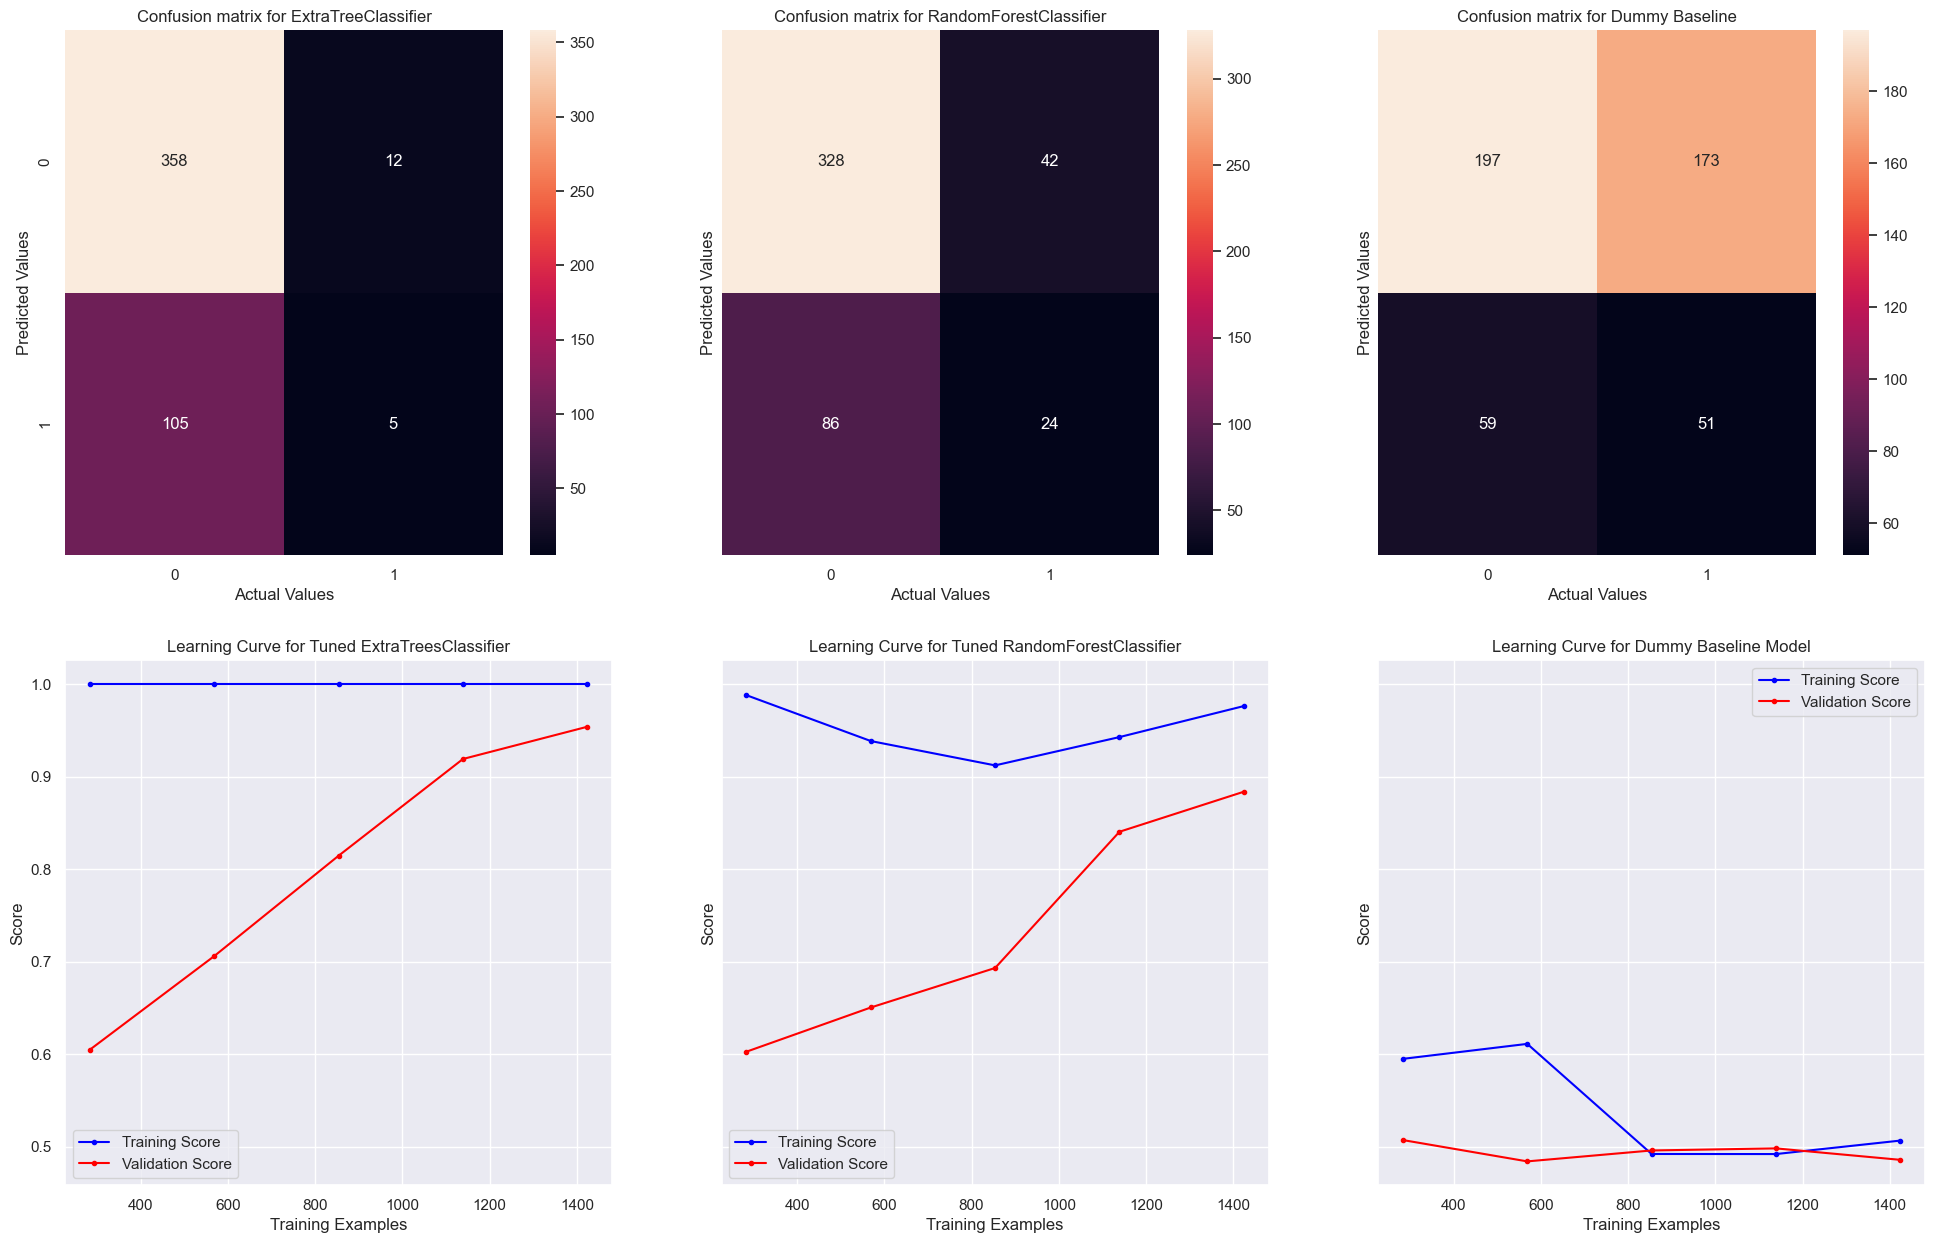

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [35]:
fig, ([ax0, ax1, ax2],[ax3, ax4, ax5]) = plt.subplots(2, 3, figsize = (24,15), sharey = 'row')

sns.heatmap(confusion_matrix(y_test, etc_y_test), annot = True, fmt = 'g', ax = ax0)
ax0.set_title("Confusion matrix for ExtraTreeClassifier")
ax0.set_ylabel("Predicted Values")
ax0.set_xlabel("Actual Values")

sns.heatmap(confusion_matrix(y_test, rfc_y_test), annot = True, fmt = 'g', ax = ax1)
ax1.set_title("Confusion matrix for RandomForestClassifier")
ax1.set_ylabel("Predicted Values")
ax1.set_xlabel("Actual Values")

sns.heatmap(confusion_matrix(y_test,dummy_y_test_hat), annot= True, fmt = "g", ax = ax2)
ax2.set_title("Confusion matrix for Dummy Baseline")
ax2.set_ylabel("Predicted Values")
ax2.set_xlabel("Actual Values")

plot_learning_curve("Tuned ExtraTreesClassifier",etc_tuned, X_train, y_train, np.arange(0.2,1.1,0.2), 5, ax=ax3)
plot_learning_curve("Tuned RandomForestClassifier",rfc_tuned, X_train, y_train, np.arange(0.2,1.1,0.2), 5, ax=ax4)
plot_learning_curve("Dummy Baseline Model", dummy_model, X_train, y_train, np.arange(0.2,1.1,0.2), 5, ax=ax5)

plt.show()

We can read the confusion matrix as follows: <br>
<div style="text-align:center">
    <img src="./images/confusion_matrix.png" alt="Image showing confusion matrix">
</div><br>


Plotting a ROC curve on unseen data to measure the performance of the model.

c:\Users\Hong Yi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
c:\Users\Hong Yi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


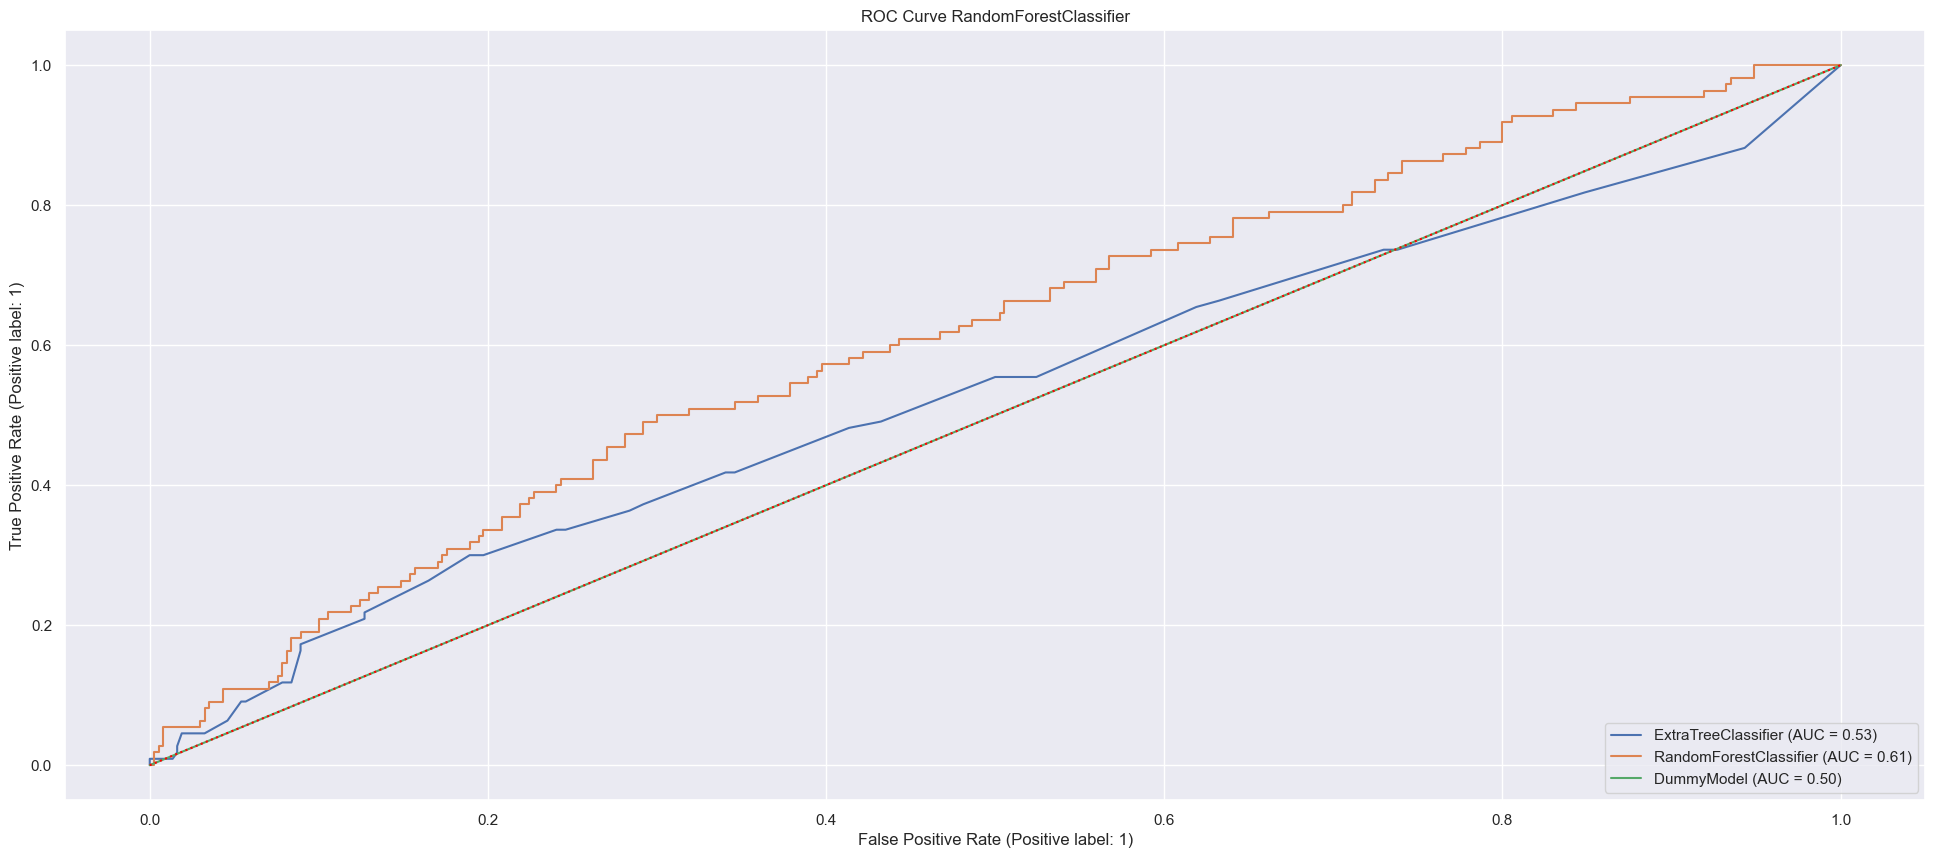

In [36]:
fig, ax = plt.subplots(figsize=(24, 10))
# selecting the 3 models to be plotted
RocCurveDisplay.from_estimator(etc_tuned, X_test, y_test, ax=ax, name="ExtraTreeClassifier")
RocCurveDisplay.from_estimator(rfc_tuned, X_test, y_test, ax=ax, name="RandomForestClassifier")
RocCurveDisplay.from_estimator(dummy_model, X_test, y_test, ax=ax, name="DummyModel")

#generating a 50% line on the graph.
x = np.linspace(0, 1, 2)
ax.plot(x, x, ":", color="red")

ax.set_title("ROC Curve RandomForestClassifier")
plt.show()

From the above metrics, we can determine that RandomForestClassifier is the best model to use. It has the highest f1_score, as well as the best Area Under the Curve (AUC). While it's learning curve may not be the highest, we can see that both the training and validation score are increasing with the number of samples given. From this, we can infer that if more samples were provided, the model is likely to perform even better.
<br><br>
Comparing the selected model to a dummy baseline, we can see that the selected model is much better, as it actually improves with more samples given, and also has predictions of a much higher quality, with a higher AUC score as compared to the dummy baseline.

<hr>
<font size = 5>Intepreting & Visualizing model.</font>
<hr>

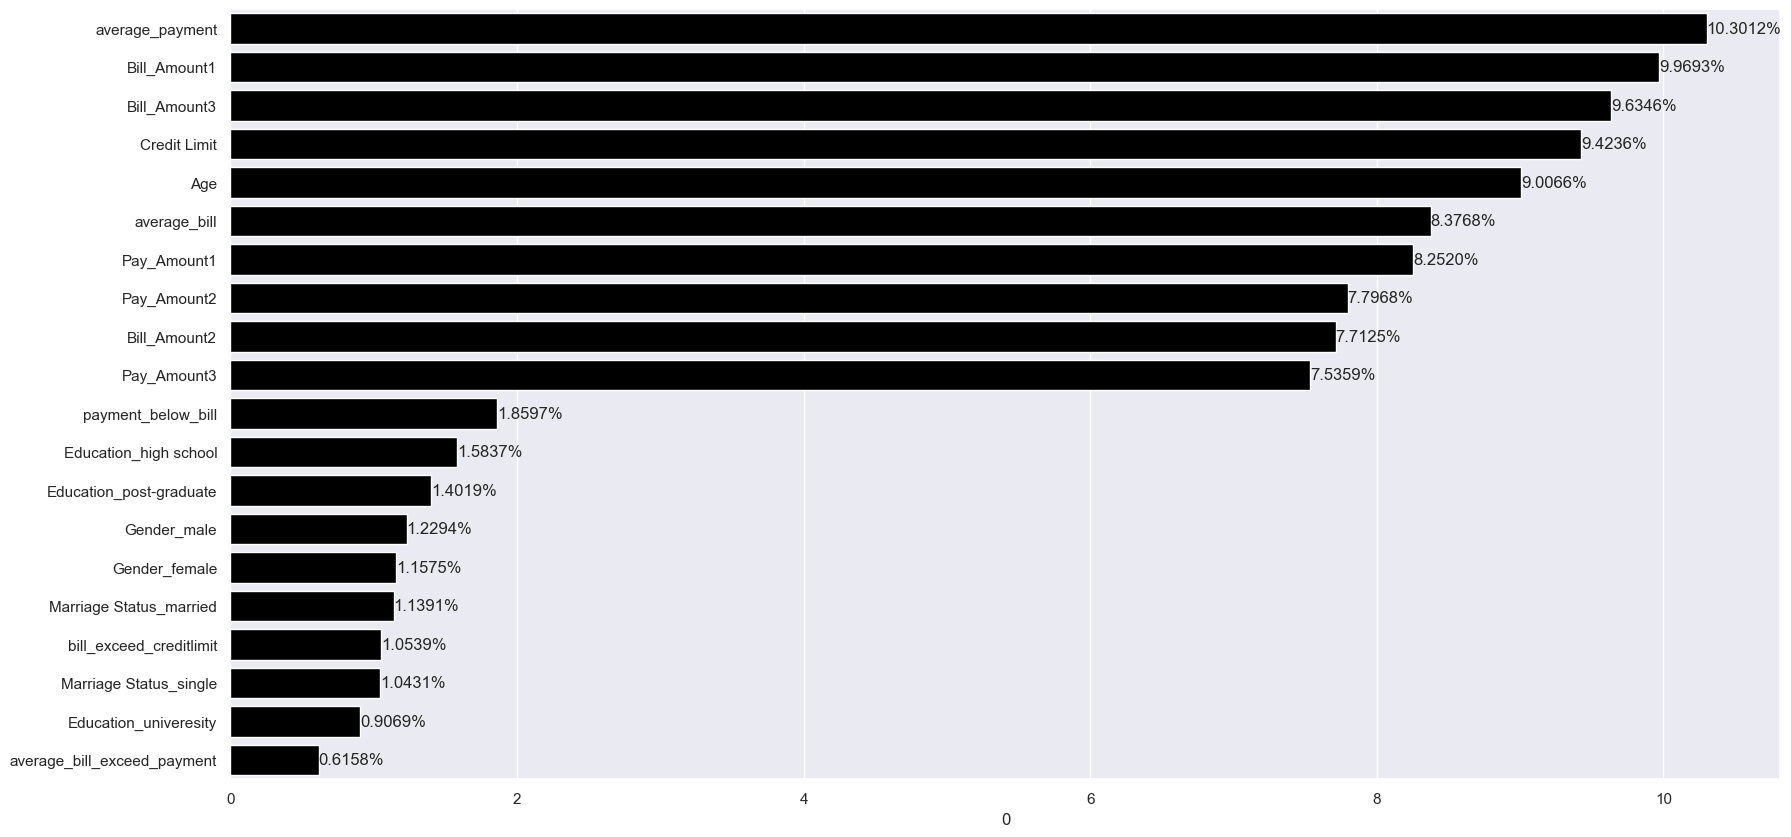

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
feat_importances = pd.DataFrame(rfc_tuned.feature_importances_, index = X_train.columns)
feat_importances = feat_importances.sort_values(0, ascending= False)
feat_importances[0] = feat_importances[0]*100
sns.barplot(x = feat_importances[0], y = feat_importances.index, color = "black")
for i in ax.containers:
    ax.bar_label(i, fmt = '%.4f%%')
plt.show()

From the above graph, we can see that there are two distinct clusters of features, one which the model considered was important, and one which was not. From this, we can see that our feature engineering was relatively successful, with the features 'average_payment' and 'average_bill' being in the top cluster.
We can also see that the features which matter the most are the "Bill_Amount1", "average_payment" and "Age" features.

Using the below code, we can visualize how the model made it's decisions in the tree form. As the output is too big, the output shall be saved as a file that can be found in the same folder as this file. <br>

In [ ]:
pickle.dump(rfc_tuned, open("random_forest_classifier.p", "wb"))
rfc_tuned_saved = pickle.load(open("random_forest_classifier.p", "rb"))
dot_data = export_graphviz(rfc_tuned_saved[-1], out_file=None, filled=True, rounded=True, special_characters=True, proportion=True, impurity=True, class_names=["Default", "Non-defafult"],)
print(dot_data)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<X<SUB>5</SUB> &le; -0.393<br/>gini = 0.5<br/>samples = 100.0%<br/>value = [0.488, 0.512]<br/>class = Non-defafult>, fillcolor="#f6fafe"] ;
1 [label=<X<SUB>1</SUB> &le; 0.561<br/>gini = 0.393<br/>samples = 20.8%<br/>value = [0.269, 0.731]<br/>class = Non-defafult>, fillcolor="#82c1ef"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<X<SUB>4</SUB> &le; 0.157<br/>gini = 0.445<br/>samples = 13.0%<br/>value = [0.335, 0.665]<br/>class = Non-defafult>, fillcolor="#9dcef2"] ;
1 -> 2 ;
3 [label=<X<SUB>17</SUB> &le; -0.83<br/>gini = 0.417<br/>samples = 12.2%<br/>value = [0.296, 0.704]<br/>class = Non-defafult>, fillcolor="#8cc6f0"] ;
2 -> 3 ;
4 [label=<X<SUB>2</SUB> &le; -0.677<br/>gini = 0.464<br/>samples = 5.5%<br/>value = [0.366, 0.634]<br/>class = Non-defafult>, fillcolor="#abd5f4"] ;
3 -> 4 ;
5 [label=<X<SUB>2</SUB> &le; -0.695<br/

<hr>
<font size = 6>Final conclusions</font>
<hr><br>
From the above, we can see that in attempting to predict which clients are most likely to default on their credit card payments, the bank should prioritize looking at the amounts they paid for previous bills, then look at the age of the customer. This is as the model considered these features as the most important during training, hence the bank should also follow suit in it's pursuit of risk mitigation.
<br><br>
When attempting to maintain the model in the future, the bank should look into providing more data for training, in the form of more samples, or a extended payment history of the customer. We can clearly see from the learning curve that the selected model benefits from having more samples. <br><br>
One big limitation of the model now, is the low amount of data given, with only 1600 samples. Furthermore, the imbalanced nature of the dataset also makes it difficult for the model to see when a customer would actually default.

__References__: <br>
1) Investopedia. (2023). Default: What It Means, What Happens When You Default, Examples. [online] Available at: https://www.investopedia.com/terms/d/default2.asp#:~:text=A%20default%20is%20a%20missed,or%20your%20monthly%20mortgage%20payment. [Accessed 5 May 2023].
<br>